In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
from itertools import compress
filterwarnings('ignore')

ES shop 1 year orders...

### Data loading, cleaning & formatting

In [18]:
data = pd.read_csv('one_year_es_shop_orders_sp_cross_selling.dsv', sep=';', low_memory=False)

In [20]:
data.sample(5)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
3738583,464181844,108901694,17/04/2018 00:00,12:22,15,3233624,"6,99","2,8445","1,7842","6,3545",...,50,857,"0,368",2128,"0,368",08/02/2018 21:58,08/02/2019 23:59,51.0,3.0,"2,99"
2893672,481600292,113276796,22/06/2018 00:00,00:49,15,2461870,"37,98","13,4073","5,982","34,5273",...,107,2068,"0,7",17963,"0,4752",03/05/2017 16:00,14/05/2020 23:59,52.0,3.0,"5,99"
2856424,504239034,118949935,13/09/2018 00:00,20:08,15,16037566,0,"-0,35","-0,739",0,...,7,2068,"0,4468",2072,"0,4468",NaN,NaN,NaN,NaN,NaN
4617349,451139090,105793353,02/03/2018 00:00,22:13,15,4539074,"21,99","4,4509","0,7834","19,9909",...,31,252,1,81397,"0,6141",NaN,NaN,NaN,NaN,NaN
1970812,460900504,108080591,04/04/2018 00:00,23:34,15,3164095,"0,99","0,6682","0,246","0,8182",...,38,34,"0,4331",71978,"0,3976",NaN,NaN,NaN,NaN,NaN


In [21]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644196 entries, 0 to 4644195
Data columns (total 23 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           object
OSP_4_LEAD_P_PG_ID              int64
OSP_4_LEAD_P_PG_SHARE           object
CZP_START_DATE                  object
CZP_EXPIRY_DATE                 object
CZP_ZTQ_ID                      float64
CZP_PERCENTAGE                  float64
CZP_PRICE                       objec

In [22]:
data[data['SCM_N_ORDER_NR'] == 95555239][data.columns[5:]]

,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,SCM_AP_ID,SCM_AS_ID,SCM_MASTER_AP_ID,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
98,9211834,"16,99","2,5413","-3,5776","14,0413",68457,1884646,68457,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
99,9211834,"3,3356","0,8554","0,4414","3,0323",55062,1662647,64829,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
100,9211834,"3,3205","0,8515","0,4394","3,0187",64829,1662647,64829,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
101,9211834,"3,3339","0,8549","0,4412","3,0308",55166,1662647,64829,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
102,9211834,"4,7422","1,1946","0,7301","4,3111",26315,1950538,29467,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
103,9211834,"4,7536","1,1974","0,7319","4,3214",29466,1950538,29467,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
104,9211834,"4,7527","1,1972","0,7318","4,3206",26317,1950538,29467,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
105,9211834,"4,7416","1,1944","0,7301","4,3105",29467,1950538,29467,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
106,9211834,"4,99","1,614","1,0448","4,124",33641,557451,33641,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN
107,9211834,"21,99","6,8136","0,0951","18,1736",69558,1915656,69558,38,2068,"0,3084",95904,"0,2908",NaN,NaN,NaN,NaN,NaN


In [23]:
def get_date(x):
    return x.split(' ')[0]

In [24]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [25]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format='%d/%m/%Y')

In [26]:
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'

In [27]:
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [28]:
data['CZP_START_DATE'] = pd.to_datetime(data['CZP_START_DATE'], format="%d/%m/%Y %H:%M")
data['CZP_EXPIRY_DATE'] = pd.to_datetime(data['CZP_EXPIRY_DATE'], format="%d/%m/%Y %H:%M")

In [29]:
data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]

In [30]:
data['CZP_PRICE'] = [float(str(i).replace(',','.')) for i in data['CZP_PRICE'].values]
data['OSP_3_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_3_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]

In [31]:
#boolean mask with duplicated orders due to SP as True
dupl_mask = [len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values]

In [32]:
#get duplicated order IDs
dup_orders = data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique()[dupl_mask].index.values

In [33]:
len(dup_orders)

3894

In [34]:
sp_acq_dup_orders = list(data[data['SCM_N_ORDER_NR'].isin(dup_orders)][data[data['SCM_N_ORDER_NR'].isin(dup_orders)]['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique())
len(sp_acq_dup_orders)

3857

In [35]:
no_sp_acq_dup_orders = [i for i in dup_orders if i not in sp_acq_dup_orders]
len(no_sp_acq_dup_orders)

37

In [36]:
#Let's get incorrect duplicated indexes instead of order_id to exclude them and select the correct data subset
dup_indexes = []

for i in sp_acq_dup_orders:
    o_id = data[data['SCM_N_ORDER_NR'] == i]
    old_sp_date = min(o_id['CZP_START_DATE'])
    old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
    dup_indexes.append(old_sp_index)

In [37]:
len(dup_indexes)

3857

In [38]:
for i in no_sp_acq_dup_orders:
    c_id = data[data['SCM_N_ORDER_NR'] == i]['CUS_N_KEY_CUSTOMER'].unique()[0]
    cust_orders = data[data['CUS_N_KEY_CUSTOMER'] == c_id]
    sp_order = cust_orders[cust_orders['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique()
    if i < sp_order:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        new_non_valid_sp_date = max(o_id['CZP_START_DATE'])
        new_sp_index = o_id[o_id['CZP_START_DATE'] == new_non_valid_sp_date].index.values
        dup_indexes.append(new_sp_index)
    else:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        old_sp_date = min(o_id['CZP_START_DATE'])
        old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
        dup_indexes.append(old_sp_index)

In [39]:
len(dup_indexes)

3894

In [40]:
#Get a flatten list of indexes
dupl_ind = [i for lista in dup_indexes for i in lista]

print('Duplicated rows detected: ', len(dupl_ind))
print('Start dropping..')

#Drop duplicated indexes
data.drop(dupl_ind, inplace=True)

#0 printed, in order to be sure there are no orders duplicated remaining...
print('Number of order IDs having more than one SP_START_DATE now: ',
      sum(len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values))

Duplicated rows detected:  26768
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [42]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [43]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [44]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [73]:
data['MAX_SALES_O_POS'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('max')
data['IS_LEAD_AS'] = (data['SCM_SALES_BMF'] == data['MAX_SALES_O_POS']) * 1 * data['SCM_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [45]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [47]:
#Get brands per PG4
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [51]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [60]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
PPR_N_LEVEL4_ID      2006 non-null int64
PPR_V_LEVEL4_DESC    2006 non-null object
BRAND                2006 non-null object
dtypes: int64(1), object(2)
memory usage: 47.1+ KB


In [52]:
brands.sample(10)

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
209,229408,229408 - Alpha Natural,Alpha Natural
567,314,314 - Whiskas,Whiskas
372,574,574 - Landschildkröten,Landschildkröten
1748,360,360 - Papeterie,Papeterie
964,118136,118136 - Lily's Kitchen,Lily's Kitchen
976,180361,180361 - ★ Wolf of Wilderness,★ Wolf of Wilderness
158,49146,49146 - Exclusion,Exclusion
323,1292,1292 - Supreme,Supreme
1979,238105,238105 - ★ zooplus Classic,★ zooplus Classic
1301,2616,2616 - Eagle Pack,Eagle Pack


In [56]:
#Get physical articles with their PG structure
ap_pg = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [57]:
ap_pg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 9 columns):
AP_ID       62994 non-null int64
PP_ID       62994 non-null int64
L1_PG_ID    62994 non-null int64
L2_PG_ID    62993 non-null float64
L3_PG_ID    62537 non-null float64
L4_PG_ID    60229 non-null float64
L5_PG_ID    29125 non-null float64
L6_PG_ID    18 non-null float64
L7_PG_ID    0 non-null float64
dtypes: float64(6), int64(3)
memory usage: 4.3 MB


In [58]:
ap_pg = ap_pg[['AP_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

In [59]:
ap_pg.sample(10)

,AP_ID,L3_PG_ID,L4_PG_ID
49387,16393,251,14648
41334,15382,252,18152
55807,4973,18,394
34329,21693,65830,9863
61255,77096,153317,153276
36428,61859,1106,71296
58732,28827,2471,45188
43109,32242,65830,30667
15211,50066,8038,14375
953,7250,2068,2083


In [63]:
#Merge both tables to add the brand for each AP_ID
ap_pg_brand = pd.merge(ap_pg, brands, how='left', left_on='L4_PG_ID', right_on='PPR_N_LEVEL4_ID')

In [64]:
ap_pg_brand.sample(20)

,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
27039,25964,65830,30667,30667,30667 - Reitstiefel,Reitstiefel
51095,32954,18,1441,1441,1441 - Fleischstreifen & Fleischsticks,Fleischstreifen & Fleischsticks
24219,3762,251,312,312,312 - Premium / Advance,Premium / Advance
37919,73938,251,40052,40052,40052 - Mastery,Mastery
18963,25087,2068,2332,2332,2332 - Shiny Cat,Shiny Cat
9288,10667,42,146,146,146 - Häuschen,Häuschen
47364,491,1248,1264,1264,1264 - Gesundheit und Pflege,Gesundheit und Pflege
51223,35660,9,75,75,75 - Hundekissen,Hundekissen
49700,18838,2068,2127,2127,2127 - Almo Nature,Almo Nature
329,2375,17,1437,1437,1437 - Aufkleber,Aufkleber


In [65]:
data = pd.merge(data, ap_pg_brand, how='left', left_on='SCM_AP_ID', right_on='AP_ID')

In [69]:
data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']] = data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']].fillna(0).astype(int)

In [70]:
data.sample(10)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,D84,D168,D252,D336,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
4387144,414880456,97246884,2017-10-29,01:34,15,9330423,-4.10,-3.7273,-3.7273,-3.7273,...,2018-01-15,2018-04-09,2018-07-02,2018-09-24,0,0,0,0,NaN,NaN
1116524,490816183,115580654,2018-07-26,10:53,15,14535681,10.99,5.1626,1.5421,9.0826,...,2017-12-25,2018-03-19,2018-06-11,2018-09-03,73457,301,10331,10331,10331 - ★ Tigerino,★ Tigerino
1705193,422911725,99147936,2017-11-25,18:29,15,7717426,11.99,3.2200,2.0735,10.9000,...,2017-12-26,2018-03-20,2018-06-12,2018-09-04,65182,2068,2632,2632,2632 - ★ Cosma,★ Cosma
1748005,411659438,96510087,2017-10-17,18:40,15,15308456,19.99,7.6707,-1.4443,16.5207,...,2018-01-09,2018-04-03,2018-06-26,2018-09-18,25890,2190,10623,10623,10623 - Einstiegshilfe,Einstiegshilfe
38192,410659833,96275542,2017-10-13,21:47,15,15430998,4.99,1.5964,1.2188,4.5364,...,2018-01-05,2018-03-30,2018-06-22,2018-09-14,20345,2068,3155,3155,3155 - Schesir,Schesir
2737152,477679197,112288703,2018-06-07,13:56,15,20415836,19.99,6.2927,1.7167,18.1727,...,2018-08-30,2018-11-22,2019-02-14,2019-05-09,64704,2068,39209,39209,39209 - Hill's Prescription Diet,Hill's Prescription Diet
3910473,492528441,116004568,2018-08-01,13:55,15,13634579,2.99,2.5223,2.5223,2.5223,...,2018-02-21,2018-05-16,2018-08-08,2018-10-31,0,0,0,0,NaN,NaN
4361226,459562821,107756226,2018-03-31,11:12,15,8722836,-1.97,-1.7044,-1.7044,-1.7044,...,2018-05-17,2018-08-09,2018-11-01,2019-01-24,0,0,0,0,NaN,NaN
4528943,484614825,114011340,2018-07-02,19:58,15,3603689,0.00,0.0000,0.0000,0.0000,...,2018-01-15,2018-04-09,2018-07-02,2018-09-24,9795,3156,3880,3880,3880 - alte Praemien,alte Praemien
4389126,413426757,96913192,2017-10-23,21:02,15,3101362,0.00,-0.1700,-0.2212,0.0000,...,2017-12-28,2018-03-22,2018-06-14,2018-09-06,65112,29,239,239,239 - Schaufeln & Vorleger,Schaufeln & Vorleger


In [71]:
data.loc[2359877]

SCM_N_ORDER_POS_NR                        488396880
SCM_N_ORDER_NR                            114966012
TDT_T_KEY_ORDER_DATE            2018-07-16 00:00:00
THR_C_KEY_ORDER_HOUR                          22:08
SIT_N_KEY_SITE                                   15
CUS_N_KEY_CUSTOMER                         16845090
SCM_SALES_BMF                                 -2.51
SCM_D_FINANCE_CM1                           -2.2406
SCM_D_FINANCE_CM2                           -2.2406
SCM_D_ORIG_FINANCE_ORDER_NET                -2.2406
SCM_AP_ID                                         0
SCM_AS_ID                                         6
SCM_MASTER_AP_ID                              42715
OSP_KO_COUNT_NET                                 13
OSP_3_LEAD_P_PG_ID                              251
OSP_3_LEAD_P_PG_SHARE                        0.5967
OSP_4_LEAD_P_PG_ID                           170799
OSP_4_LEAD_P_PG_SHARE                        0.5967
CZP_START_DATE                  2018-07-09 00:00:00
CZP_EXPIRY_D

In [74]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'AP_ID',
       'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID', 'PPR_V_LEVEL4_DESC', 'BRAND',
       'MAX_SALES_O_POS', 'IS_LEAD_AS', 'LEAD_AS_ID'],
      dtype='object')

In [77]:
#data.to_pickle("./one_year_orders_es_shop_sp_cross_selling.pkl")

### Order level

In [2]:
data = pd.read_pickle("./one_year_orders_es_shop_sp_cross_selling.pkl")

In [3]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'SCM_AP_ID': lambda x: list(x),
          'L4_PG_ID': lambda x: list(x),
          'BRAND': lambda x: list(x),
          'PPR_V_LEVEL4_DESC': lambda x: list(x),
          'L3_PG_ID': lambda x: list(x),
          'SCM_AS_ID': lambda x: list(x),
          'LEAD_AS_ID': max,
          'SCM_MASTER_AP_ID': lambda x: list(x),
          'CZP_ZTQ_ID': min, 
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [4]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [5]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [6]:
orders.columns = ['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET',
       'OSP_KO_COUNT_NET', 'SCM_AP_ID_list', 'L4_PG_ID_list',
       'BRAND_list', 'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list',
       'SCM_AS_ID_list', 'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list',
       'CZP_ZTQ_ID', 'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168',
       'D252', 'D336']

In [7]:
orders['SP_DISC'] = [42715 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [8]:
orders['SP_DISC'].value_counts()

False    717357
True     359967
Name: SP_DISC, dtype: int64

We need to calculate, for each order, sales per PG3/PG4/BRAND... 

In [9]:
orders['PG3_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L3_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [10]:
orders['PG4_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L4_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [11]:
orders['BRAND_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['BRAND_list'], 
                                                                                   orders['SCM_SALES_BMF_list']))]

In [13]:
orders['PG3_AGGSALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG3_SALES']]

In [14]:
orders['PG4_AGGSALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                        for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG4_SALES']]

In [15]:
orders['BRAND_AGGSALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                        for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['BRAND_SALES']]

In [16]:
orders.sample(10)[['SCM_SALES_BMF_list', 'SCM_AP_ID_list', 'SP_DISC', 'L3_PG_ID_list', 'PG3_SALES', 'PG3_AGGSALES', 
                   'L4_PG_ID_list', 'PG4_SALES', 'PG4_AGGSALES', 'BRAND_list', 'BRAND_SALES', 'BRAND_AGGSALES']]

,SCM_SALES_BMF_list,SCM_AP_ID_list,SP_DISC,L3_PG_ID_list,PG3_SALES,PG3_AGGSALES,L4_PG_ID_list,PG4_SALES,PG4_AGGSALES,BRAND_list,BRAND_SALES,BRAND_AGGSALES
448657,[42.99],[68774],False,[38],"[(38, 42.99)]","[(38, 42.99)]",[72369],"[(72369, 42.99)]","[(72369, 42.99)]",[für Gelenke & Knochen],"[(für Gelenke & Knochen, 42.99)]","[(für Gelenke & Knochen, 42.99)]"
841595,"[3.99, 19.99]","[0, 71785]",False,"[0, 29]","[(0, 3.99), (29, 19.99)]","[(29, 19.99), (0, 3.99)]","[0, 35032]","[(0, 3.99), (35032, 19.99)]","[(35032, 19.99), (0, 3.99)]","[nan, Feliway]","[(nan, 3.99), (Feliway, 19.99)]","[(Feliway, 19.99), (nan, 0)]"
337610,"[-5.43, 96.99, 83.88]","[0, 76918, 60535]",True,"[0, 251, 18]","[(0, -5.43), (251, 96.99), (18, 83.88)]","[(251, 96.99), (18, 83.88), (0, -5.43)]","[0, 255, 393]","[(0, -5.43), (255, 96.99), (393, 83.88)]","[(255, 96.99), (393, 83.88), (0, -5.43)]","[nan, Eukanuba, Hundekekse & Hundekuchen]","[(nan, -5.43), (Eukanuba, 96.99), (Hundekekse ...","[(Eukanuba, 96.99), (Hundekekse & Hundekuchen,..."
464168,"[1.19, 1.99, 17.99, 17.99, 1.99]","[52416, 32605, 70320, 70320, 50350]",False,"[34, 2068, 301, 301, 2068]","[(34, 1.19), (2068, 1.99), (301, 17.99), (301,...","[(301, 35.98), (2068, 3.98), (34, 1.19)]","[71978, 2072, 10331, 10331, 2072]","[(71978, 1.19), (2072, 1.99), (10331, 17.99), ...","[(10331, 35.98), (2072, 3.98), (71978, 1.19)]","[Knuspersnacks, Gourmet Gold, ★ Tigerino, ★ Ti...","[(Knuspersnacks, 1.19), (Gourmet Gold, 1.99), ...","[(★ Tigerino, 35.98), (Gourmet Gold, 3.98), (K..."
427711,"[69.99, 66.99, 24.99]","[21062, 72445, 21064]",False,"[2190, 251, 2190]","[(2190, 69.99), (251, 66.99), (2190, 24.99)]","[(2190, 94.98), (251, 66.99)]","[10618, 18245, 10618]","[(10618, 69.99), (18245, 66.99), (10618, 24.99)]","[(10618, 94.98), (18245, 66.99)]","[Kunststoff Transportboxen, Acana, Kunststoff ...","[(Kunststoff Transportboxen, 69.99), (Acana, 6...","[(Kunststoff Transportboxen, 94.98), (Acana, 6..."
313480,"[86.99, 2.9]","[52747, 0]",False,"[251, 0]","[(251, 86.99), (0, 2.9)]","[(251, 86.99), (0, 2.9)]","[2108, 0]","[(2108, 86.99), (0, 2.9)]","[(2108, 86.99), (0, 2.9)]","[Lupo Natural / Sensitive, nan]","[(Lupo Natural / Sensitive, 86.99), (nan, 2.9)]","[(Lupo Natural / Sensitive, 86.99), (nan, 0)]"
1040416,"[0.0, 20.99, 33.98]","[65052, 72449, 67330]",False,"[29, 252, 2068]","[(29, 0.0), (252, 20.99), (2068, 33.98)]","[(2068, 33.98), (252, 20.99), (29, 0.0)]","[239, 19467, 3155]","[(239, 0.0), (19467, 20.99), (3155, 33.98)]","[(3155, 33.98), (19467, 20.99), (239, 0.0)]","[Schaufeln & Vorleger, Acana, Schesir]","[(Schaufeln & Vorleger, 0.0), (Acana, 20.99), ...","[(Schesir, 33.98), (Acana, 20.99), (Schaufeln ..."
978061,"[3.99, 19.99]","[0, 75344]",False,"[0, 2190]","[(0, 3.99), (2190, 19.99)]","[(2190, 19.99), (0, 3.99)]","[0, 10623]","[(0, 3.99), (10623, 19.99)]","[(10623, 19.99), (0, 3.99)]","[nan, Einstiegshilfe]","[(nan, 3.99), (Einstiegshilfe, 19.99)]","[(Einstiegshilfe, 19.99), (nan, 0)]"
4888,"[9.99, 84.99]","[0, 61093]",False,"[0, 251]","[(0, 9.99), (251, 84.99)]","[(251, 84.99), (0, 9.99)]","[0, 682]","[(0, 9.99), (682, 84.99)]","[(682, 84.99), (0, 9.99)]","[nan, Royal Canin Size]","[(nan, 9.99), (Royal Canin Size, 84.99)]","[(Royal Canin Size, 84.99), (nan, 0)]"
209392,"[7.49, 7.49, 20.99, 20.99, 20.99]","[57542, 57476, 73458, 73458, 73458]",False,"[2068, 2068, 301, 301, 301]","[(2068, 7.49), (2068, 7.49), (301, 20.99), (30...","[(301, 62.97), (2068, 14.98)]","[2073, 2073, 10331, 10331, 10331]","[(2073, 7.49), (2073, 7.49), (10331, 20.99), (...","[(10331, 62.97), (2073, 14.98)]","[Hill’s Science Plan, Hill’s Science Plan, ★ T...","[(Hill’s Science Plan, 7.49), (Hill’s Science ...","[(★ Tigerino, 62.97), (Hill’s Science Plan, 14..."


In [17]:
#orders.to_pickle("./one_year_aggregated_orders_es_shop_sp_cross_selling.pkl")

### Customer level

In [ ]:
orders = pd.read_pickle("./one_year_aggregated_orders_es_shop_sp_cross_selling.pkl")

In [18]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET',
       'SCM_AP_ID_list', 'L4_PG_ID_list', 'BRAND_list',
       'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list', 'SCM_AS_ID_list',
       'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'SP_DISC',
       'PG3_SALES', 'PG4_SALES', 'BRAND_SALES', 'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES'],
      dtype='object')

In [19]:
agg_ord_ops = {
              'SCM_N_ORDER_NR': len,
              'TDT_T_KEY_ORDER_DATE': lambda x: list(x.dt.date),
              'SCM_SALES_BMF_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'SCM_MASTER_AP_ID_list': lambda x: list(x),
              'CZP_ZTQ_ID': lambda x: list(set(list(x))),
              'CZP_START_DATE': lambda x: list(set(list(x.dt.date))),
              'CZP_EXPIRY_DATE': lambda x: list(set(list(x.dt.date))),
              'PG3_AGGSALES': lambda x: list(x),
              'PG4_AGGSALES': lambda x: list(x),
              'BRAND_AGGSALES': lambda x: list(x),
              'SP_DISC': lambda x: list(x),
              'D28': max,
              'D56': max,
              'D84': max,
              'D168': max,
              'D252': max,
              'D336': max
              }

In [20]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [21]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [22]:
customers.columns = ['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len',
       'TDT_T_KEY_ORDER_DATE_list', 'SCM_SALES_BMF_sum',
       'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES', 'SP_DISC', 'D28', 'D56', 'D84', 'D168',
       'D252', 'D336']

In [23]:
customers['O_TIMEDELTAS'] = [[(i - j).days for i, j in list(zip(o_list[1:], o_list[:-1]))] 
                             for o_list in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [24]:
customers['FLAT_PG3_SALES'] = [[k for j in i for k in j] for i in customers['PG3_AGGSALES'].values]

In [25]:
customers['FLAT_PG4_SALES'] = [[k for j in i for k in j] for i in customers['PG4_AGGSALES'].values]

In [26]:
customers['FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in customers['BRAND_AGGSALES'].values]

In [27]:
customers['TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG3_SALES']]

In [28]:
customers['TOTAL_PG4_SALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                                for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG4_SALES']]

In [29]:
customers['TOTAL_BRAND_SALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_BRAND_SALES']]

In [30]:
customers.to_pickle("./customers_es_shop_sp_cross_selling.pkl")

In [31]:
del customers['FLAT_PG3_SALES']

In [32]:
del customers['FLAT_PG4_SALES']

In [33]:
del customers['FLAT_BRAND_SALES']

### Framework

***SCENARIOS***

+ **A.**	Customers that have a savingsplan and customers who do not have a savingsplan
+ **B.**	Customers who have a savingsplan but did not have one for a while before and then compare those periods (As we want compare AOV and shares within other aspects, it would be better to request a minimum amount of orders with/without SP instead of fixing a time period, what will be done in Scenario A).

In [2]:
customers = pd.read_pickle("./customers_es_shop_sp_cross_selling.pkl")

In [3]:
customers.head(10)[customers.columns[:10]]

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum
0,72564,8,"[2017-11-11, 2018-01-10, 2018-01-25, 2018-02-2...",1353.08,"[300.04, 98.88, 151.59, 52.78, 100.69, 139.08,...",439.58,"[115.37, 25.7, 53.08, 13.62, 36.58, 45.96, 59....",207.85,"[64.95, 9.14, 20.89, 0.57, 16.51, 9.05, 30.87,...",1220.62
1,124777,1,[2018-08-04],553.58,[553.58],183.88,[183.88],93.98,[93.98],498.76
2,185605,1,[2017-10-26],23.15,[23.15],8.83,[8.83],1.37,[1.37],19.13
3,198539,5,"[2018-02-07, 2018-04-06, 2018-04-22, 2018-05-2...",354.00,"[142.4, 67.32, 50.73, 49.48, 44.07]",122.65,"[36.26, 25.76, 18.68, 21.55, 20.41]",-7.51,"[-0.99, -8.62, 1.5, 3.07, -2.48]",339.11
4,245530,1,[2017-11-17],85.44,[85.44],24.39,[24.39],8.46,[8.46],77.67
5,246884,1,[2018-08-04],102.99,[102.99],38.84,[38.84],-5.82,[-5.82],99.88
6,254564,2,"[2017-12-12, 2018-09-07]",136.17,"[46.47, 89.7]",26.21,"[7.97, 18.25]",9.80,"[-0.16, 9.96]",123.79
7,266476,23,"[2017-10-16, 2017-10-22, 2017-10-31, 2017-11-2...",4051.89,"[262.67, 125.35, 104.31, 211.46, 91.26, 146.57...",911.80,"[65.57, 36.69, 28.71, 47.09, 25.66, 28.73, 40....",146.19,"[-3.64, 19.23, 0.59, 3.08, 14.75, 9.28, 2.57, ...",3573.83
8,270025,1,[2017-11-30],98.17,[98.17],1.89,[1.89],-5.31,[-5.31],81.81
9,292607,2,"[2018-03-25, 2018-03-29]",128.96,"[70.78, 58.18]",26.99,"[9.44, 17.55]",14.15,"[3.32, 10.83]",117.00


In [4]:
customers.head(10)[customers.columns[10:19]]

,SCM_D_ORIG_FINANCE_ORDER_NET_list,OSP_KO_COUNT_NET_list,SCM_MASTER_AP_ID_list,CZP_ZTQ_ID,CZP_START_DATE,CZP_EXPIRY_DATE,PG3_AGGSALES,PG4_AGGSALES,BRAND_AGGSALES
0,"[272.76, 89.89, 137.81, 47.98, 91.06, 122.59, ...","[68, 69, 70, 71, 72, 73, 74, 75]","[[50173, 69102, 69102, 69102, 69102, 42715, 45...","[51.0, 52.0]","[2018-04-10, 2017-04-23]","[2018-04-10, 2021-04-10]","[[(252, 182.95), (2068, 118.39), (34, 7.99), (...","[[(3641, 169.96), (2071, 35.99), (248782, 23.9...","[[(★ Smilla, 169.96), (Felix, 35.99), (★ Conce..."
1,[498.76],[13],"[[70868, 64800, 65558, 52750, 28056, 81066, 55...",[nan],[nan],[nan],"[[(857, 134.94), (2068, 107.96), (252, 77.97),...","[[(10728, 107.96), (314, 77.97), (14463, 74.97...","[[(Whiskas, 205.91), (★ Lukullus Naturkost, 12..."
2,[19.13],[46],"[[65187, 6168, 54350, 62808, 66600]]",[nan],[nan],[nan],"[[(18, 11.18), (409, 7.98), (0, 3.99), (251, 0...","[[(1306, 11.18), (413, 4.99), (0, 3.99), (2613...","[[(vom Geflügel, 11.18), (Shampoo & Fellpflege..."
3,"[137.74, 64.09, 49.25, 46.85, 41.19]","[94, 95, 96, 97, 102]","[[18136, 18132, 18132, 77023, 42715], [6168, 5...",[52.0],[2015-12-06],[2018-12-11],"[[(2068, 134.91), (301, 14.99), (0, -7.5)], [(...","[[(17871, 134.91), (818, 14.99), (0, -7.5)], [...","[[(Porta 21, 134.91), (Intersand Extreme Class..."
4,[77.67],[43],"[[71892, 42715, 71893, 71893]]",[52.0],[2016-11-22],[2019-11-22],"[[(857, 89.94), (0, -4.5)]]","[[(2718, 89.94), (0, -4.5)]]","[[(Animonda Integra, 89.94), (nan, 0)]]"
5,[99.88],[9],"[[81456, 81456, 42715, 6168, 42225]]",[51.0],[2018-08-04],[2019-08-04],"[[(251, 95.98), (0, 4.02), (48963, 2.99)]]","[[(149697, 95.98), (0, 7.01)]]","[[(Libra, 95.98), (unknown, 2.99), (nan, 0), (..."
6,"[42.25, 81.55]","[39, 45]","[[24527, 8277, 42715], [8277, 24527, 42715]]",[53.0],"[2017-03-01, 2018-03-09]","[2019-03-09, 2018-03-01]","[[(857, 31.99), (18, 17.98), (0, -3.5)], [(857...","[[(3314, 31.99), (394, 17.98), (0, -3.5)], [(3...","[[(Terra Canis, 31.99), (Zahnpflege Snacks, 17..."
7,"[227.79, 110.25, 91.11, 185.55, 80.74, 121.13,...","[271, 272, 273, 274, 275, 276, 277, 278, 279, ...","[[17543, 52846, 60593, 23843, 71391, 5482, 175...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[nan],[nan],"[[(2068, 143.92), (301, 95.96), (29, 51.98), (...","[[(2632, 95.96), (3243, 95.96), (128, 51.98), ...","[[(Golden Grey / Golden, 95.96), (★ Cosma, 95...."
8,[81.81],[87],"[[6168, 64669, 42715]]",[52.0],[2017-04-08],[2020-04-08],"[[(2068, 92.97), (0, 5.2)]]","[[(39209, 92.97), (0, 5.2)]]","[[(Hill's Prescription Diet, 92.97), (nan, 0),..."
9,"[64.11, 52.89]","[130, 133]","[[20886, 42225, 20886, 68468, 42715, 68469, 20...",[51.0],[2018-03-25],[2019-03-25],"[[(207553, 69.98), (48963, 2.99), (2430, 0.0),...","[[(207617, 69.98), (0, 0.8), (9272, 0.0)], [(2...","[[(Spot-On, 69.98), (unknown, 2.99), (nan, 0),..."


In [5]:
customers.head(10)[customers.columns[19:]]

,SP_DISC,D28,D56,D84,D168,D252,D336,O_TIMEDELTAS,FLAT_PG3_SALES,FLAT_PG4_SALES,FLAT_BRAND_SALES,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES
0,"[True, True, True, True, True, True, True, True]",2017-12-09,2018-01-06,2018-02-03,2018-04-28,2018-07-21,2018-10-13,"[60, 15, 26, 49, 29, 50, 62]","[(252, 182.95), (2068, 118.39), (34, 7.99), (0...","[(3641, 169.96), (2071, 35.99), (248782, 23.96...","[(★ Smilla, 169.96), (Felix, 35.99), (★ Concep...","[(252, 658.59), (2068, 437.57), (207553, 127.9...","[(3641, 564.26), (207615, 127.92), (2071, 109....","[(★ Smilla, 597.25), (Halsband, 127.92), (Feli..."
1,[False],2018-09-01,2018-09-29,2018-10-27,2019-01-19,2019-04-13,2019-07-06,[],"[(857, 134.94), (2068, 107.96), (252, 77.97), ...","[(10728, 107.96), (314, 77.97), (14463, 74.97)...","[(Whiskas, 205.91), (★ Lukullus Naturkost, 122...","[(857, 134.94), (2068, 107.96), (252, 77.97), ...","[(10728, 107.96), (314, 77.97), (14463, 74.97)...","[(Whiskas, 205.91), (★ Lukullus Naturkost, 122..."
2,[False],2017-11-23,2017-12-21,2018-01-18,2018-04-12,2018-07-05,2018-09-27,[],"[(18, 11.18), (409, 7.98), (0, 3.99), (251, 0.0)]","[(1306, 11.18), (413, 4.99), (0, 3.99), (2613,...","[(vom Geflügel, 11.18), (Shampoo & Fellpflege,...","[(18, 11.18), (409, 7.98), (0, 3.99), (251, 0.0)]","[(1306, 11.18), (413, 4.99), (0, 3.99), (2613,...","[(vom Geflügel, 11.18), (Shampoo & Fellpflege,..."
3,"[True, True, True, True, True]",2018-03-07,2018-04-04,2018-05-02,2018-07-25,2018-10-17,2019-01-09,"[58, 16, 29, 128]","[(2068, 134.91), (301, 14.99), (0, -7.5), (206...","[(17871, 134.91), (818, 14.99), (0, -7.5), (81...","[(Porta 21, 134.91), (Intersand Extreme Classi...","[(2068, 179.57), (301, 103.95), (252, 44.99), ...","[(17871, 164.89), (818, 103.95), (720, 44.99),...","[(Porta 21, 164.89), (Intersand Extreme Classi..."
4,[True],2017-12-15,2018-01-12,2018-02-09,2018-05-04,2018-07-27,2018-10-19,[],"[(857, 89.94), (0, -4.5)]","[(2718, 89.94), (0, -4.5)]","[(Animonda Integra, 89.94), (nan, 0)]","[(857, 89.94), (0, -4.5)]","[(2718, 89.94), (0, -4.5)]","[(Animonda Integra, 89.94), (nan, 0)]"
5,[True],2018-09-01,2018-09-29,2018-10-27,2019-01-19,2019-04-13,2019-07-06,[],"[(251, 95.98), (0, 4.02), (48963, 2.99)]","[(149697, 95.98), (0, 7.01)]","[(Libra, 95.98), (unknown, 2.99), (nan, 0), (n...","[(251, 95.98), (0, 4.02), (48963, 2.99)]","[(149697, 95.98), (0, 7.01)]","[(Libra, 95.98), (unknown, 2.99), (nan, 0), (n..."
6,"[True, True]",2018-01-09,2018-02-06,2018-03-06,2018-05-29,2018-08-21,2018-11-13,[269],"[(857, 31.99), (18, 17.98), (0, -3.5), (857, 6...","[(3314, 31.99), (394, 17.98), (0, -3.5), (3314...","[(Terra Canis, 31.99), (Zahnpflege Snacks, 17....","[(857, 99.97), (18, 46.45), (0, -10.25)]","[(3314, 99.97), (394, 46.45), (0, -10.25)]","[(Terra Canis, 99.97), (Zahnpflege Snacks, 46...."
7,"[False, False, False, False, False, False, Fal...",2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,2018-09-17,"[6, 9, 21, 4, 13, 13, 11, 27, 15, 8, 7, 19, 14...","[(2068, 143.92), (301, 95.96), (29, 51.98), (0...","[(2632, 95.96), (3243, 95.96), (128, 51.98), (...","[(Golden Grey / Golden, 95.96), (★ Cosma, 95.9...","[(2068, 2527.63), (301, 909.27), (252, 451.2),...","[(2632, 1481.55), (3243, 909.27), (2137, 522.6...","[(★ Cosma, 1481.55), (Golden Grey / Golden, 90..."
8,[True],2017-12-28,2018-01-25,2018-02-22,2018-05-17,2018-08-09,2018-11-01,[],"[(2068, 92.97), (0, 5.2)]","[(39209, 92.97), (0, 5.2)]","[(Hill's Prescription Diet, 92.97), (nan, 0), ...","[(2068, 92.97), (0, 5.2)]","[(39209, 92.97), (0, 5.2)]","[(Hill's Prescription Diet, 92.97), (nan, 0), ..."
9,"[True, True]",2018-04-22,2018-05-20,2018-06-17,2018-09-09,2018-12-02,2019-02-24,[4],"[(207553, 69.98), (48963, 2.99), (2430, 0.0), ...","[(207617, 69.98), (0, 0.8), (9272, 0.0), (2204...","[(Spot-On, 69.98), (unknown, 2.99), (nan, 0), ...","[(207553, 69.98), (1400, 59.98), (48963, 2.99)...","[(207617, 69.98), (2204, 59.98), (9272, 0.0), ...","[(Spot-On, 69.98), (Aktiv & Fit, 59.98), (unkn..."


#### Scenario A: Customers with and without SP

Let's label with 1 every customer having at least one order affected by SP discount, 0 otherwise

In [6]:
customers['SP_CUS'] = [any([(str(j) != 'nan') for j in i]) * 1 for i in customers['CZP_START_DATE'].values]

In [7]:
customers['SP_CUS'].value_counts()

0    246689
1     68527
Name: SP_CUS, dtype: int64

- The standard KPIs: **Sales, CM1, CM2, AOV, Order Frequency** during a **fixed time period**

- **Number of PG3s** the customer bought in and **Sales Share** in the according class 

In [8]:
last_date_df = datetime.datetime.strptime('30092018', "%d%m%Y").date()
last_date_df

datetime.date(2018, 9, 30)

Using last date in our dataset (30/09/2018), we will go back in time following different windows (28-56-84-168-252-336 days) and check if the resulting date is equal or greater to the first order date we have in our dataset. In case is not, we would label the customer as not suitable for this window.

In [9]:
customers['SUIT_28D'] = [((last_date_df - timedelta(days=28)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [10]:
customers['SUIT_56D'] = [((last_date_df - timedelta(days=56)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [11]:
customers['SUIT_84D'] = [((last_date_df - timedelta(days=84)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [12]:
customers['SUIT_168D'] = [((last_date_df - timedelta(days=168)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [13]:
customers['SUIT_252D'] = [((last_date_df - timedelta(days=252)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [14]:
customers['SUIT_336D'] = [((last_date_df - timedelta(days=336)) >= i[0]) * 1 for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [15]:
customers.groupby('SP_CUS', as_index=False)[['SUIT_28D', 'SUIT_56D', 'SUIT_84D', 
                                             'SUIT_168D', 'SUIT_252D', 'SUIT_336D']].sum()

,SP_CUS,SUIT_28D,SUIT_56D,SUIT_84D,SUIT_168D,SUIT_252D,SUIT_336D
0,0,235081,224738,214313,177249,129600,46009
1,1,67927,67194,66387,62725,55136,26440


Let's get the time window of 252 days...

Now we will extract the suitable customers for the calculation (SUIT_252D = 1) and then apply over their data a boolean mask to get the performance after 252 days from their 1st order on, along the dataset.

In [16]:
cus_252_days = customers[customers['SUIT_252D'] == 1].copy()

In [17]:
cus_252_days['MASK'] = [[i.date() >= d for d in j] for i, j in list(zip(cus_252_days['D252'], cus_252_days['TDT_T_KEY_ORDER_DATE_list']))]

In [18]:
cus_252_days['D252_SALES'] = [list(compress(i, j)) for i, j in list(zip(cus_252_days['SCM_SALES_BMF_list'], 
                                                                        cus_252_days['MASK']))]

In [19]:
cus_252_days['D252_CM1'] = [list(compress(i, j)) for i, j in list(zip(cus_252_days['SCM_D_FINANCE_CM1_list'], 
                                                                      cus_252_days['MASK']))]

In [20]:
cus_252_days['D252_CM2'] = [list(compress(i, j)) for i, j in list(zip(cus_252_days['SCM_D_FINANCE_CM2_list'], 
                                                                      cus_252_days['MASK']))]

In [21]:
cus_252_days['D252_NET_SALES'] = [list(compress(i, j)) for i, j in list(zip(cus_252_days['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                      cus_252_days['MASK']))]

In [22]:
cus_252_days['D252_PG3_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(cus_252_days['PG3_AGGSALES'], 
                                                                               cus_252_days['MASK']))]

In [23]:
cus_252_days['D252_FLAT_PG3_AGGSALES'] = [[k for j in i for k in j] for i in cus_252_days['D252_PG3_AGGSALES'].values]

In [24]:
cus_252_days['D252_TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in cus_252_days['D252_FLAT_PG3_AGGSALES']]

In [25]:
cus_252_days['D252_TOTAL_SALES'] = [sum(i) for i in cus_252_days['D252_SALES'].values]

In [26]:
cus_252_days['D252_AOV'] = [np.round(sum(i) / float(len(i)), 2) for i in cus_252_days['D252_SALES'].values]

In [27]:
cus_252_days['D252_ORDERS'] = [len(i) for i in cus_252_days['D252_SALES'].values]

In [28]:
cus_252_days['D252_TOTAL_CM1'] = [sum(i) for i in cus_252_days['D252_CM1'].values]

In [29]:
cus_252_days['D252_TOTAL_CM2'] = [sum(i) for i in cus_252_days['D252_CM2'].values]

In [30]:
cus_252_days['D252_TOTAL_NET_SALES'] = [sum(i) for i in cus_252_days['D252_NET_SALES'].values]

In [31]:
cus_252_days['D252_CM1%'] = np.round(cus_252_days['D252_TOTAL_CM1'] / cus_252_days['D252_TOTAL_NET_SALES'] * 100, 2)

In [32]:
cus_252_days['D252_CM2%'] = np.round(cus_252_days['D252_TOTAL_CM2'] / cus_252_days['D252_TOTAL_NET_SALES'] * 100, 2)

In [33]:
cus_252_days['D252_DICT_PG3_SALES'] = [{j[0]: j[1] for j in i} for i in cus_252_days['D252_TOTAL_PG3_SALES'].values]

In [34]:
cus_252_days['D252_DICT_PG3_SALES_NO_DISC'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in cus_252_days['D252_TOTAL_PG3_SALES'].values]

In [35]:
cus_252_days['D252_DIFF_PG3'] = [len(i.keys()) for i in cus_252_days['D252_DICT_PG3_SALES']]

In [36]:
cus_252_days['D252_DIFF_PG3_NO_DISC'] = [len(i.keys()) for i in cus_252_days['D252_DICT_PG3_SALES_NO_DISC']]

In [37]:
cus_252_days['D252_DICT_PG3_SHARE'] = [{a: np.round(b/sum(i.values())*100, 2) for a, b in list(zip(i.keys(), i.values()))}
                                        for i in cus_252_days['D252_DICT_PG3_SALES'].values]

In [38]:
cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'] = [{a: np.round(b/sum(i.values())*100, 2) for a, b in list(zip(i.keys(), i.values()))}
                                        for i in cus_252_days['D252_DICT_PG3_SALES_NO_DISC'].values]

In [39]:
cus_252_days['PG_23_SHARE'] = [i[23] if 23 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_23_SHARE'].min(), cus_252_days['PG_23_SHARE'].max()

(0.0, 100.0)

In [40]:
cus_252_days['PG_38_SHARE'] = [i[38] if 38 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_38_SHARE'].min(), cus_252_days['PG_38_SHARE'].max()

(0.0, 100.0)

In [41]:
cus_252_days['PG_251_SHARE'] = [i[251] if 251 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_251_SHARE'].min(), cus_252_days['PG_251_SHARE'].max()

(0.0, 100.0)

In [42]:
cus_252_days['PG_252_SHARE'] = [i[252] if 252 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_252_SHARE'].min(), cus_252_days['PG_252_SHARE'].max()

(0.0, 100.0)

In [43]:
cus_252_days['PG_857_SHARE'] = [i[857] if 857 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_857_SHARE'].min(), cus_252_days['PG_857_SHARE'].max()

(0.0, 100.0)

In [44]:
cus_252_days['PG_2068_SHARE'] = [i[2068] if 2068 in i.keys() else 0 for i in cus_252_days['D252_DICT_PG3_SHARE_NO_DISC'].values]
cus_252_days['PG_2068_SHARE'].min(), cus_252_days['PG_2068_SHARE'].max()

(0.0, 100.0)

##### Total sales

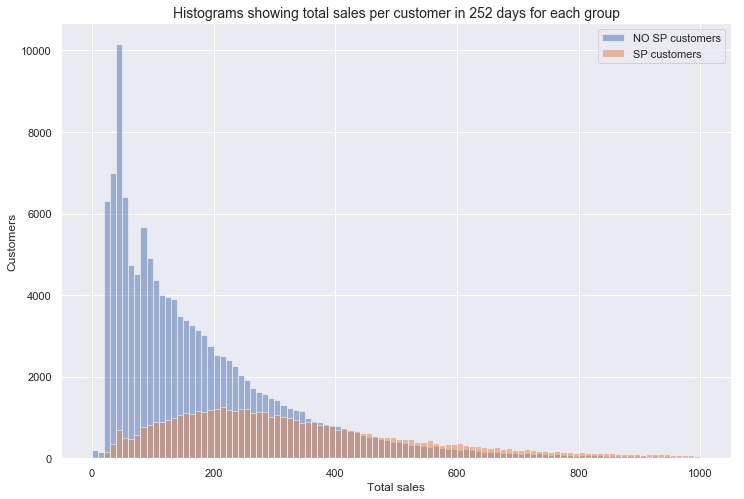

,NO SP customers,SP customers
count,129600.00,55136.00
mean,193.07,407.97
std,214.93,912.92
min,-13.75,-22.31
25%,64.99,191.74
50%,135.97,311.29
75%,250.43,494.90
max,17429.92,192687.90


In [45]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total sales per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Total sales')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_TOTAL_SALES'].hist(bins=100, range=(0, 1000), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['D252_TOTAL_SALES'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### Order frequency

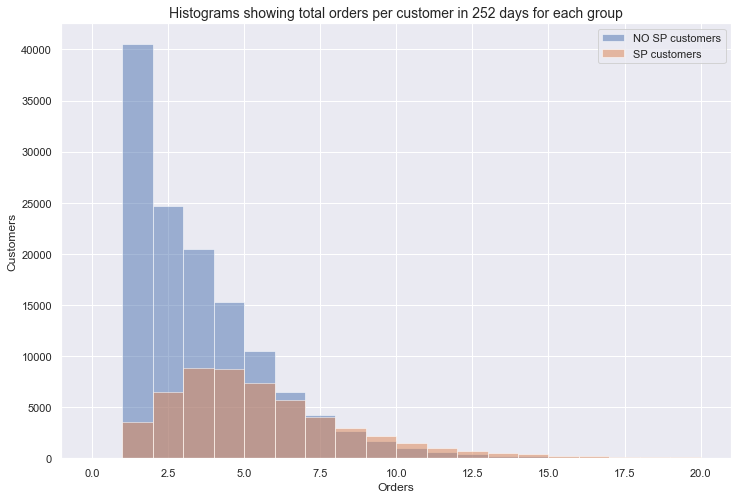

,NO SP customers,SP customers
count,129600.00,55136.00
mean,3.14,5.34
std,2.48,10.74
min,1.00,1.00
25%,1.00,3.00
50%,2.00,4.00
75%,4.00,7.00
max,64.00,2359.00


In [46]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total orders per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Orders')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_ORDERS'].hist(bins=20, range=(0, 20), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['D252_ORDERS'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### AOV

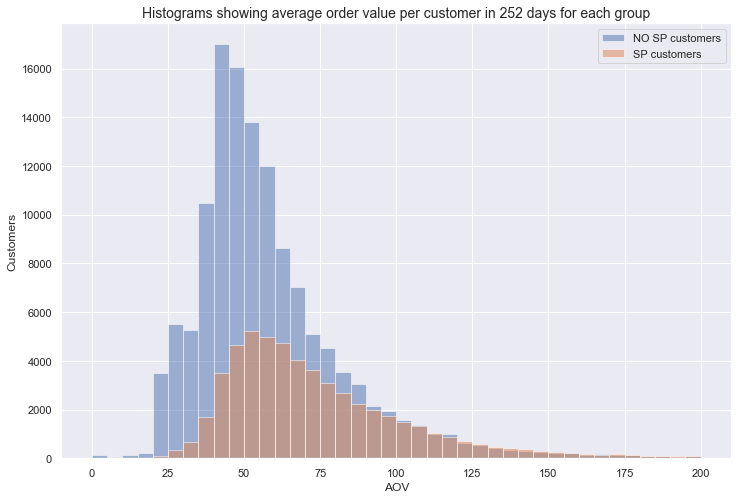

,NO SP customers,SP customers
count,129600.00,55136.00
mean,59.17,76.52
std,29.96,39.62
min,-11.00,-22.31
25%,42.29,52.60
50%,52.34,66.91
75%,68.17,89.41
max,903.92,1248.26


In [47]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing average order value per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_AOV'].hist(bins=40, range=(0, 200), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['D252_AOV'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### CM1%

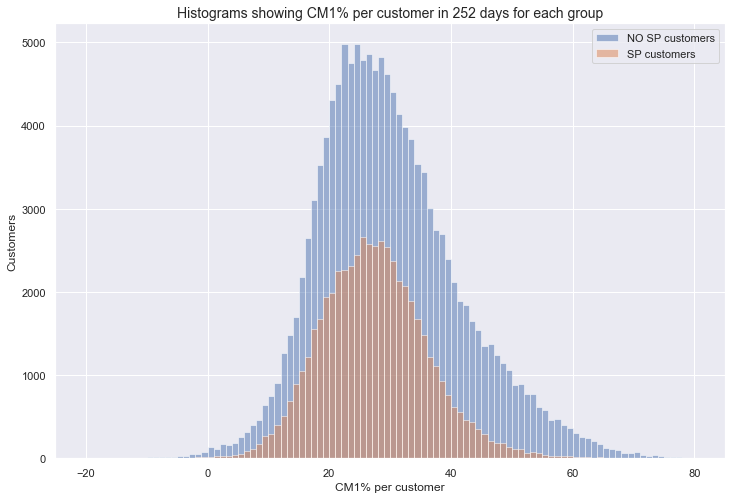

,NO SP customers,SP customers
count,129202.00,55024.00
mean,30.06,27.36
std,11.93,8.85
min,0.00,0.00
25%,21.83,21.31
50%,28.52,26.97
75%,36.65,32.69
max,100.00,100.00


In [48]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM1% per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM1% per customer')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_CM1%'].hist(bins=100, range=(-20, 80), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                pd.DataFrame(data_cluster[data_cluster['D252_CM1%'].between(0, 100)]['D252_CM1%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### CM2%

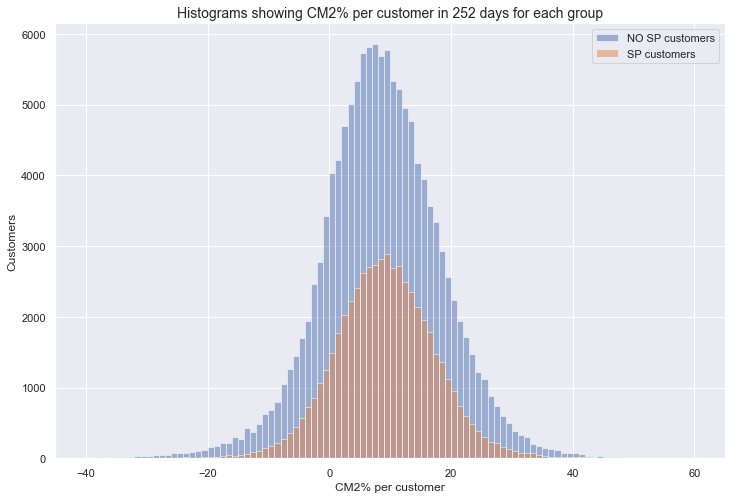

,NO SP customers,SP customers
count,107803.00,48494.00
mean,11.64,11.03
std,8.46,7.04
min,0.00,0.00
25%,5.64,5.84
50%,10.32,10.21
75%,16.09,15.16
max,100.00,100.00


In [49]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM2% per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM2% per customer')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_CM2%'].hist(bins=100, range=(-40, 60), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                pd.DataFrame(data_cluster[data_cluster['D252_CM2%'].between(0, 100)]['D252_CM2%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### Number of PG3s the customer bought 

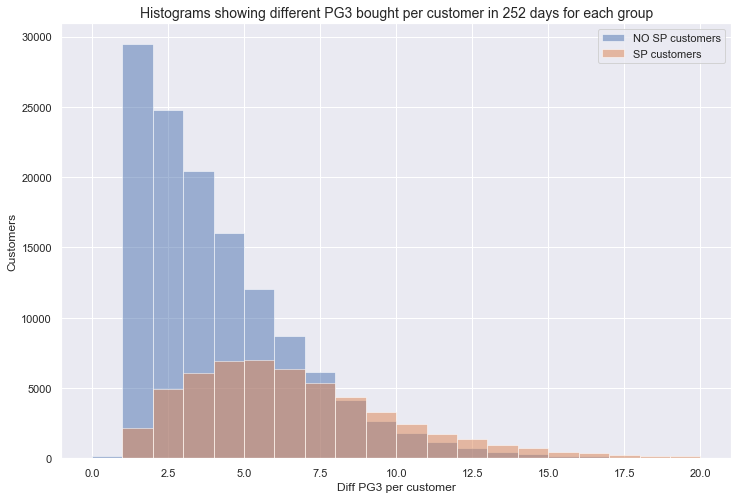

,NO SP customers,SP customers
count,129600.00,55136.00
mean,3.67,6.17
std,2.69,3.54
min,0.00,0.00
25%,2.00,4.00
50%,3.00,6.00
75%,5.00,8.00
max,26.00,37.00


In [50]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing different PG3 bought per customer in 252 days for each group', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Diff PG3 per customer')

for i in np.sort(cus_252_days['SP_CUS'].unique()):
    data_cluster = cus_252_days[cus_252_days['SP_CUS'] == i]
    data_cluster['D252_DIFF_PG3_NO_DISC'].hist(bins=20, range=(0, 20), alpha=0.5)
    plt.legend(['NO SP customers', 'SP customers'])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_cluster['D252_DIFF_PG3_NO_DISC'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['NO SP customers', 'SP customers']
display(concat_df)

##### PG3 shares in each group

As sales share per differents PG3 in customers with/without SP do not result very explanatory, let's move on to another way of looking at it.
For each group we will calculate the different PG3 shares over the total sales.

In [51]:
cus_252_days['SP_CUS'].value_counts()

0    129600
1     55136
Name: SP_CUS, dtype: int64

In [52]:
sp_cus_252_flat_pg3_sales = [j for i in cus_252_days[cus_252_days['SP_CUS'] == 1]['D252_FLAT_PG3_AGGSALES'] for j in i]

In [53]:
sp_cus_252_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in sp_cus_252_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in sp_cus_252_flat_pg3_sales])], key= lambda x: x[1], reverse=True) 
                            

In [54]:
sp_cus_252_pg3_dict_sales_no_disc = {i[0]: i[1] for i in sp_cus_252_pg3_sales if i[0] != 0}

In [55]:
sp_cus_252_pg3_dict_sales_share = {a: np.round(b/sum(sp_cus_252_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(sp_cus_252_pg3_dict_sales_no_disc.keys(),
                                                                          sp_cus_252_pg3_dict_sales_no_disc.values()))}

In [56]:
filter_sp_cus_252_pg3_dict_sales_share = {x: y for x, y in list(zip(sp_cus_252_pg3_dict_sales_share.keys(),
                                                                    sp_cus_252_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [57]:
sum(filter_sp_cus_252_pg3_dict_sales_share.values())

90.15799999999999

In [58]:
no_sp_cus_252_flat_pg3_sales = [j for i in cus_252_days[cus_252_days['SP_CUS'] == 0]['D252_FLAT_PG3_AGGSALES'] for j in i]

In [59]:
no_sp_cus_252_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in no_sp_cus_252_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in no_sp_cus_252_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [60]:
no_sp_cus_252_pg3_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_cus_252_pg3_sales if i[0] != 0}

In [61]:
no_sp_cus_252_pg3_dict_sales_share = {a: np.round(b/sum(no_sp_cus_252_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(no_sp_cus_252_pg3_dict_sales_no_disc.keys(),
                                                                          no_sp_cus_252_pg3_dict_sales_no_disc.values()))}

In [62]:
filter_no_sp_cus_252_pg3_dict_sales_share = {x: y for x, y in list(zip(no_sp_cus_252_pg3_dict_sales_share.keys(),
                                                                no_sp_cus_252_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [63]:
sum(filter_no_sp_cus_252_pg3_dict_sales_share.values())

89.924

In [64]:
filter_sp_cus_252_pg3_dict_sales_share

{9: 1.056,
 18: 3.755,
 23: 1.506,
 29: 1.586,
 34: 1.628,
 251: 33.939,
 252: 20.364,
 301: 7.272,
 857: 3.445,
 2068: 12.726,
 207553: 2.881}

In [65]:
filter_no_sp_cus_252_pg3_dict_sales_share

{9: 1.593,
 18: 3.202,
 23: 2.054,
 29: 1.712,
 34: 1.135,
 251: 36.068,
 252: 21.232,
 301: 6.157,
 409: 1.19,
 857: 2.129,
 2068: 8.735,
 2190: 1.056,
 207553: 3.661}

In [66]:
sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_sp_cus_252_pg3_dict_sales_share, orient='index')
no_sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_no_sp_cus_252_pg3_dict_sales_share, orient='index')

In [67]:
pg3_share_comparison = pd.concat([sp_cus_pg3_share_df,no_sp_cus_pg3_share_df], axis=1).fillna(0)
pg3_share_comparison.columns = ['SP_CUS', 'NO_SP_CUS']
pg3_share_comparison['PG3'] = pg3_share_comparison.index.values
#pg3_share_comparison['PG3'] = pg3_share_comparison['PG3'].astype(str)
pg3_share_comparison = pg3_share_comparison[['PG3', 'SP_CUS', 'NO_SP_CUS']]
pg3_share_comparison

,PG3,SP_CUS,NO_SP_CUS
9,9,1.056,1.593
18,18,3.755,3.202
23,23,1.506,2.054
29,29,1.586,1.712
34,34,1.628,1.135
251,251,33.939,36.068
252,252,20.364,21.232
301,301,7.272,6.157
409,409,0.000,1.190
857,857,3.445,2.129


In [68]:
pg3_l = list(pg3_share_comparison['PG3'].values)

In [69]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [70]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [71]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [72]:
pg3

,PG_ID,PG_SHORTLINK
0,9,hundebett
1,18,hundesnacks
2,23,kratzbaum_katzenbaum
3,29,katzentoilette
4,34,katzensnacks
5,251,hundefutter_trockenfutter
6,252,katzenfutter_trockenfutter
7,301,katzenstreu
8,409,hundepflege
9,857,hundefutter_nassfutter


In [73]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [74]:
pg3_share_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_share_comparison['PG3'].values]

In [75]:
pg3_share_comparison

,PG3,SP_CUS,NO_SP_CUS,PG3_NAME
9,9,1.056,1.593,hundebett
18,18,3.755,3.202,hundesnacks
23,23,1.506,2.054,kratzbaum_katzenbaum
29,29,1.586,1.712,katzentoilette
34,34,1.628,1.135,katzensnacks
251,251,33.939,36.068,hundefutter_trockenfutter
252,252,20.364,21.232,katzenfutter_trockenfutter
301,301,7.272,6.157,katzenstreu
409,409,0.000,1.190,hundepflege
857,857,3.445,2.129,hundefutter_nassfutter


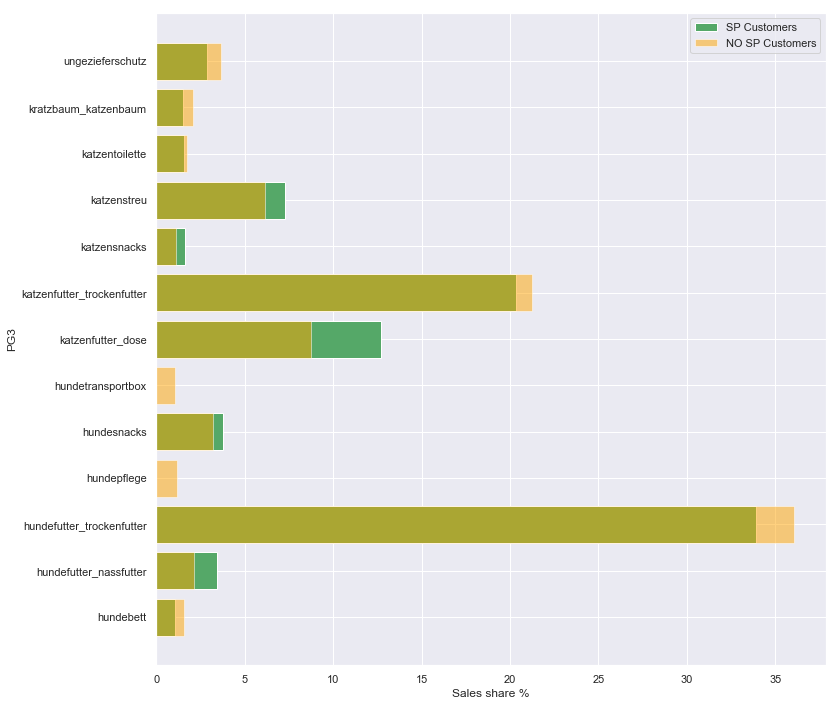

In [76]:
plt.figure(figsize=(12, 12))
x = pg3_share_comparison['PG3_NAME'].values
y = pg3_share_comparison['SP_CUS'].values
z = pg3_share_comparison['NO_SP_CUS'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.ylabel('PG3')
plt.xlabel('Sales share %')
plt.legend(['SP Customers', 'NO SP Customers'])
plt.show()

#### Scenario B: Customers with SP, analyse orders with/without SP

In [2]:
customers = pd.read_pickle("./customers_es_shop_sp_cross_selling.pkl")

In [3]:
customers['O_W_SP'] = [sum(i) for i in customers['SP_DISC'].values]

In [4]:
customers['O_WO_SP'] = customers['SCM_N_ORDER_NR_len'] - customers['O_W_SP']

In [5]:
customers['NO_SP_DISC'] = [[not j for j in i] for i in customers['SP_DISC'].values]

***Get customers with at least 3 orders without SP and and 3 orders with SP***

In [6]:
cus_scen_b = customers[(customers['O_WO_SP'] >= 3) & (customers['O_W_SP'] >= 3)].copy()

In [7]:
cus_scen_b[['O_WO_SP', 'O_W_SP']].describe().round(2)

,O_WO_SP,O_W_SP
count,2936.00,2936.00
mean,4.80,7.89
std,6.14,42.53
min,3.00,3.00
25%,3.00,4.00
50%,4.00,5.00
75%,5.00,8.00
max,287.00,2210.00


In [8]:
cus_scen_b.iloc[128]

CUS_N_KEY_CUSTOMER                                                             3233648
SCM_N_ORDER_NR_len                                                                   9
TDT_T_KEY_ORDER_DATE_list            [2017-12-28, 2018-02-01, 2018-03-23, 2018-05-2...
SCM_SALES_BMF_sum                                                               640.66
SCM_SALES_BMF_list                   [102.55, 53.42, 77.97, 51.98, 78.9, 75.96, 68....
SCM_D_FINANCE_CM1_sum                                                           220.61
SCM_D_FINANCE_CM1_list               [40.47, 18.33, 26.74, 19.32, 18.55, 30.85, 26....
SCM_D_FINANCE_CM2_sum                                                           115.99
SCM_D_FINANCE_CM2_list               [31.27, 7.72, 17.8, 9.35, 9.28, 21.16, 3.8, 4....
SCM_D_ORIG_FINANCE_ORDER_NET_sum                                                557.87
SCM_D_ORIG_FINANCE_ORDER_NET_list    [85.0, 45.47, 68.4, 47.25, 70.16, 66.7, 61.2, ...
OSP_KO_COUNT_NET_list                      

In [9]:
#Position of 1st True Value (6th value), at least we want 3 orders before so first True must be at least in position 3
np.argwhere(cus_scen_b.iloc[128]['SP_DISC'])

array([[5],
       [6],
       [7],
       [8]], dtype=int64)

In [10]:
cus_scen_b['SCEN_2B'] = [(np.argwhere(i)[0][0] >= 3) * 1 for i in cus_scen_b['SP_DISC'].values]

In [11]:
cus_scen_b['SCEN_2B_POS'] = [np.argwhere(i)[0][0] for i in cus_scen_b['SP_DISC'].values]

In [12]:
cus_scen_b['SCEN_2B'].value_counts()

1    1584
0    1352
Name: SCEN_2B, dtype: int64

In [13]:
cus_scen_2b = cus_scen_b[cus_scen_b['SCEN_2B'] == 1].copy()

In [14]:
cus_scen_2b['WO_SP_1st_POS'] = cus_scen_2b['SCEN_2B_POS'] - 3
cus_scen_2b['W_SP_last_POS'] = cus_scen_2b['SCEN_2B_POS'] + 3

In [15]:
cus_scen_2b.sample(5)['PG3_AGGSALES']

183317    [[(251, 50.99), (2068, 17.99), (40023, 12.99),...
42643     [[(252, 21.0), (301, 15.98), (2068, 3.98)], [(...
18921     [[(207553, 24.99), (18, 22.98), (221, 13.99), ...
61602     [[(252, 87.99), (301, 17.98), (857, 9.99), (34...
196072    [[(47, 21.16), (49828, 19.98), (42, 15.2), (29...
Name: PG3_AGGSALES, dtype: object

+   KPIs: Sales, AOV, CM1%, CM2%
+	Number of PG3s the customer bought in and Sales Share in the according class 
+	Spend in the classes that he did not buy before but started buying in with Savingsplan (would only work for Scenario b))
+	Average Sales Share of Royal Canin products – with/without SP
+	Average Sales Share of Hills products – with/without SP

##### Sales in 3 orders previous SP vs 3 posterior orders

In [16]:
cus_scen_2b['SALES_WO_SP'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_SALES_BMF_list'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [17]:
cus_scen_2b['SALES_W_SP'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_SALES_BMF_list'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

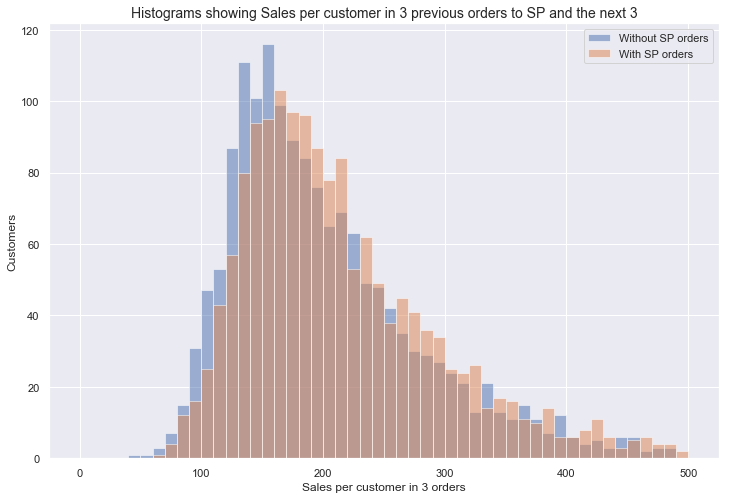

,Without SP orders,With SP orders
count,1584.00,1584.00
mean,207.74,224.98
std,101.77,120.34
min,48.65,69.28
25%,144.85,156.78
50%,184.10,197.70
75%,244.91,262.63
max,1643.66,2526.08


In [18]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing Sales per customer in 3 previous orders to SP and the next 3', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Sales per customer in 3 orders')

cus_scen_2b['SALES_WO_SP'].hist(bins=50, range=(0, 500), alpha=0.5)
cus_scen_2b['SALES_W_SP'].hist(bins=50, range=(0, 500), alpha=0.5)
plt.legend(['Without SP orders', 'With SP orders'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(cus_scen_2b['SALES_WO_SP'].describe().round(2)),
                    pd.DataFrame(cus_scen_2b['SALES_W_SP'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)

##### AOV

In [19]:
cus_scen_2b['AOV_WO_SP'] = [np.round(np.mean(x[y:z]), 2) for x, y, z in list(zip(cus_scen_2b['SCM_SALES_BMF_list'],
                                                                         cus_scen_2b['WO_SP_1st_POS'],
                                                                         cus_scen_2b['SCEN_2B_POS']))]

In [20]:
cus_scen_2b['AOV_W_SP'] = [np.round(np.mean(x[y:z]), 2) for x, y, z in list(zip(cus_scen_2b['SCM_SALES_BMF_list'],
                                                                cus_scen_2b['SCEN_2B_POS'],
                                                                cus_scen_2b['W_SP_last_POS']))]

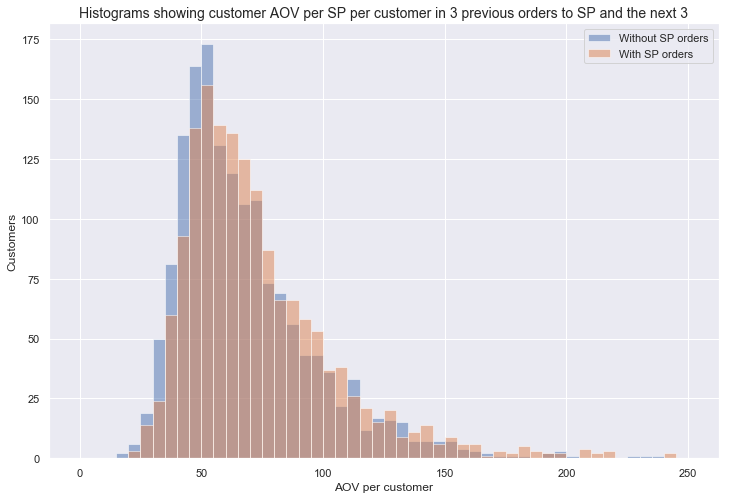

,Without SP orders,With SP orders
count,1584.00,1584.00
mean,69.25,74.99
std,33.92,40.11
min,16.22,23.09
25%,48.28,52.26
50%,61.36,65.90
75%,81.63,87.55
max,547.89,842.03


In [21]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing customer AOV per SP per customer in 3 previous orders to SP and the next 3', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV per customer')

cus_scen_2b['AOV_WO_SP'] .hist(bins=50, range=(0, 250), alpha=0.5)
cus_scen_2b['AOV_W_SP'].hist(bins=50, range=(0, 250), alpha=0.5)
plt.legend(['Without SP orders', 'With SP orders'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(cus_scen_2b['AOV_WO_SP'] .describe().round(2)),
                    pd.DataFrame(cus_scen_2b['AOV_W_SP'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)

##### CM1% & CM2%

In [22]:
cus_scen_2b['WO_SP_CM1'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_FINANCE_CM1_list'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [23]:
cus_scen_2b['SP_CM1'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_FINANCE_CM1_list'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

In [24]:
cus_scen_2b['WO_SP_CM2'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_FINANCE_CM2_list'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [25]:
cus_scen_2b['SP_CM2'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_FINANCE_CM2_list'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

In [26]:
cus_scen_2b['WO_SP_NET_SALES'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_ORIG_FINANCE_ORDER_NET_list'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [27]:
cus_scen_2b['SP_NET_SALES'] = [sum(x[y:z]) for x, y, z in list(zip(cus_scen_2b['SCM_D_ORIG_FINANCE_ORDER_NET_list'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

In [28]:
cus_scen_2b['WO_SP_CM1%'] = np.round(cus_scen_2b['WO_SP_CM1'] / cus_scen_2b['WO_SP_NET_SALES'] * 100, 2)

In [29]:
cus_scen_2b['SP_CM1%'] = np.round(cus_scen_2b['SP_CM1'] / cus_scen_2b['SP_NET_SALES'] * 100, 2) 

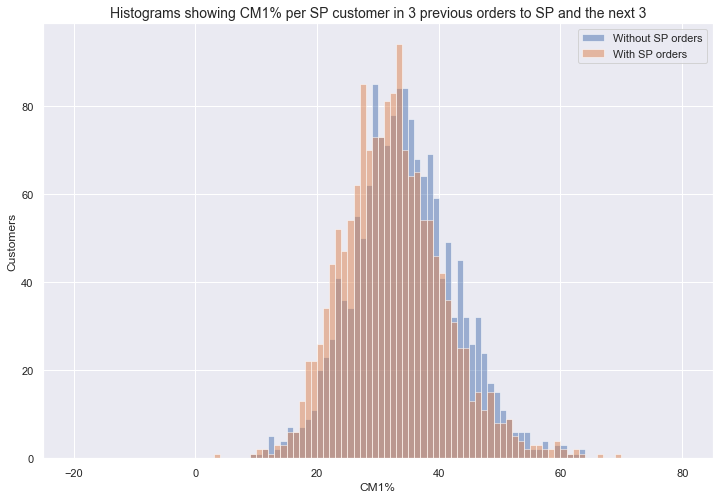

,Without SP orders,With SP orders
count,1584.00,1584.00
mean,34.35,32.55
std,8.40,8.41
min,9.68,3.29
25%,28.92,26.94
50%,33.93,32.15
75%,39.51,37.46
max,63.97,69.20


In [30]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM1% per SP customer in 3 previous orders to SP and the next 3', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM1%')

cus_scen_2b['WO_SP_CM1%'].hist(bins=100, range=(-20, 80), alpha=0.5)
cus_scen_2b['SP_CM1%'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['Without SP orders', 'With SP orders'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(cus_scen_2b['WO_SP_CM1%'].describe().round(2)),
                    pd.DataFrame(cus_scen_2b['SP_CM1%'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)

In [31]:
cus_scen_2b['WO_SP_CM2%'] = np.round(cus_scen_2b['WO_SP_CM2'] / cus_scen_2b['WO_SP_NET_SALES'] * 100, 2)

In [32]:
cus_scen_2b['SP_CM2%'] = np.round(cus_scen_2b['SP_CM2'] / cus_scen_2b['SP_NET_SALES'] * 100, 2) 

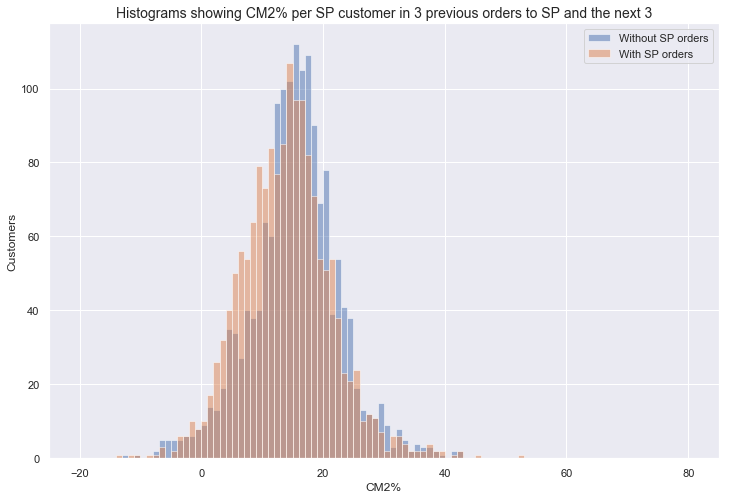

,Without SP orders,With SP orders
count,1584.00,1584.00
mean,15.29,13.91
std,7.37,7.62
min,-12.50,-47.03
25%,11.36,9.07
50%,15.49,14.04
75%,19.50,18.23
max,42.72,52.64


In [33]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM2% per SP customer in 3 previous orders to SP and the next 3', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM2%')

cus_scen_2b['WO_SP_CM2%'].hist(bins=100, range=(-20, 80), alpha=0.5)
cus_scen_2b['SP_CM2%'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['Without SP orders', 'With SP orders'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(cus_scen_2b['WO_SP_CM2%'].describe().round(2)),
                    pd.DataFrame(cus_scen_2b['SP_CM2%'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)

##### Number of PG3s the customer bought in the 3 previous orders to SP and the next 3

In [34]:
cus_scen_2b['WO_SP_PG3_SALES'] = [x[y:z] for x, y, z in list(zip(cus_scen_2b['PG3_AGGSALES'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [35]:
cus_scen_2b['SP_PG3_SALES'] = [x[y:z] for x, y, z in list(zip(cus_scen_2b['PG3_AGGSALES'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

In [36]:
cus_scen_2b['WO_SP_FLAT_PG3_AGGSALES'] = [[k for j in i for k in j] for i in cus_scen_2b['WO_SP_PG3_SALES'].values]

In [37]:
cus_scen_2b['SP_FLAT_PG3_AGGSALES'] = [[k for j in i for k in j] for i in cus_scen_2b['SP_PG3_SALES'].values]

In [38]:
cus_scen_2b['WO_SP_TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in cus_scen_2b['WO_SP_FLAT_PG3_AGGSALES']]

In [39]:
cus_scen_2b['SP_TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in cus_scen_2b['SP_FLAT_PG3_AGGSALES']]

In [40]:
cus_scen_2b['WO_SP_DICT_PG3_SALES'] = [{j[0]: j[1] for j in i} for i in cus_scen_2b['WO_SP_TOTAL_PG3_SALES'].values]

In [41]:
cus_scen_2b['WO_SP_DICT_PG3_SALES_NO_DISC'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                              for i in cus_scen_2b['WO_SP_TOTAL_PG3_SALES'].values]

In [42]:
cus_scen_2b['SP_DICT_PG3_SALES'] = [{j[0]: j[1] for j in i} for i in cus_scen_2b['SP_TOTAL_PG3_SALES'].values]

In [43]:
cus_scen_2b['SP_DICT_PG3_SALES_NO_DISC'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                              for i in cus_scen_2b['SP_TOTAL_PG3_SALES'].values]

In [44]:
cus_scen_2b['WO_SP_DIFF_PG3'] = [len(i.keys()) for i in cus_scen_2b['WO_SP_DICT_PG3_SALES']]

In [45]:
cus_scen_2b['WO_SP_DIFF_PG3_NO_DISC'] = [len(i.keys()) for i in cus_scen_2b['WO_SP_DICT_PG3_SALES_NO_DISC']]

In [46]:
cus_scen_2b['WO_SP_PG3_IDS_NO_DISC'] = [list(i.keys()) for i in cus_scen_2b['WO_SP_DICT_PG3_SALES_NO_DISC']]

In [47]:
cus_scen_2b['SP_DIFF_PG3'] = [len(i.keys()) for i in cus_scen_2b['SP_DICT_PG3_SALES']]

In [48]:
cus_scen_2b['SP_DIFF_PG3_NO_DISC'] = [len(i.keys()) for i in cus_scen_2b['SP_DICT_PG3_SALES_NO_DISC']]

In [49]:
cus_scen_2b['SP_PG3_IDS_NO_DISC'] = [list(i.keys()) for i in cus_scen_2b['SP_DICT_PG3_SALES_NO_DISC']]

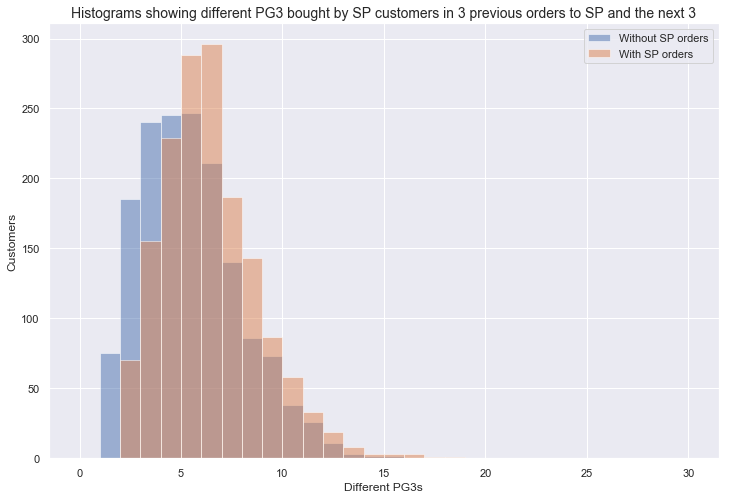

,Without SP orders,With SP orders
count,1584.00,1584.00
mean,4.97,5.95
std,2.48,2.40
min,1.00,2.00
25%,3.00,4.00
50%,5.00,6.00
75%,6.00,7.00
max,15.00,18.00


In [50]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing different PG3 bought by SP customers in 3 previous orders to SP and the next 3', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Different PG3s')

cus_scen_2b['WO_SP_DIFF_PG3_NO_DISC'].hist(bins=30, range=(0, 30), alpha=0.5)
cus_scen_2b['SP_DIFF_PG3_NO_DISC'].hist(bins=30, range=(0, 30), alpha=0.5)
plt.legend(['Without SP orders', 'With SP orders'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(cus_scen_2b['WO_SP_DIFF_PG3_NO_DISC'].describe().round(2)),
                    pd.DataFrame(cus_scen_2b['SP_DIFF_PG3_NO_DISC'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns =['Without SP orders', 'With SP orders']
display(concat_df)

In [51]:
cus_scen_2b['DIFF_PG3_UP'] = (cus_scen_2b['SP_DIFF_PG3_NO_DISC'] > cus_scen_2b['WO_SP_DIFF_PG3_NO_DISC']) * 1

In [52]:
cus_scen_2b['DIFF_PG3_UP'].value_counts()

1    955
0    629
Name: DIFF_PG3_UP, dtype: int64

##### New PG3 bought with Savingsplan 

We get now every pg3 in SP orders which are not in NO SP orders and quantify the total amount...

In [53]:
cus_scen_2b['NEW_PG3_WITH_SP'] = [[pg for pg in a if pg not in b]
                                for a, b in list(zip(cus_scen_2b['SP_PG3_IDS_NO_DISC'], cus_scen_2b['WO_SP_PG3_IDS_NO_DISC']))]

In [54]:
cus_scen_2b['LEN_NEW_PG3_WITH_SP'] = cus_scen_2b['NEW_PG3_WITH_SP'].apply(len)

In [55]:
cus_scen_2b['LEN_NEW_PG3_WITH_SP'].describe().round(2)

count    1584.00
mean        2.91
std         1.66
min         0.00
25%         2.00
50%         3.00
75%         4.00
max        13.00
Name: LEN_NEW_PG3_WITH_SP, dtype: float64

##### PG3 shares in each group

In [56]:
cus_scen_2b['WO_SP_FLAT_PG3_AGGSALES'].head()

18     [(251, 85.99), (18, 22.99), (857, 11.99), (251...
58     [(2068, 16.98), (252, 14.99), (38, 12.99), (33...
396    [(251, 53.99), (18, 3.99), (18, 37.97), (409, ...
462    [(18, 25.98), (274, 6.99), (221, 5.99), (470, ...
567    [(2068, 33.18), (301, 17.99), (2068, 49.77), (...
Name: WO_SP_FLAT_PG3_AGGSALES, dtype: object

In [57]:
cus_scen_2b['SP_FLAT_PG3_AGGSALES'].head()

18     [(251, 46.43), (1400, 33.98), (18, 33.46), (85...
58     [(9, 29.99), (301, 20.99), (38, 12.99), (48963...
396    [(251, 53.99), (48963, 2.99), (0, -1.71), (18,...
462    [(252, 48.99), (2068, 26.99), (18, 22.99), (30...
567    [(23, 139.98), (252, 80.97), (2068, 35.98), (4...
Name: SP_FLAT_PG3_AGGSALES, dtype: object

In [58]:
no_sp_flat_pg3_sales = [j for i in cus_scen_2b['WO_SP_FLAT_PG3_AGGSALES'].values for j in i]

In [59]:
no_sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in no_sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in no_sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [60]:
no_sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_pg3_sales if i[0] != 0}

In [61]:
no_sp_pg3_dict_sales_share = {a: np.round(b/sum(no_sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(no_sp_pg3_dict_sales_no_disc.keys(),
                                                                          no_sp_pg3_dict_sales_no_disc.values()))}

In [62]:
filter_no_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(no_sp_pg3_dict_sales_share.keys(),
                                                                no_sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [63]:
sum(filter_no_sp_pg3_dict_sales_share.values())

91.531

In [64]:
no_sp_pg3_dict_sales_no_disc

{9: 4933.54,
 15: 2641.23,
 16: 1578.29,
 18: 12835.75,
 20: 2926.3,
 23: 7875.14,
 29: 7638.5,
 33: 3605.48,
 34: 5263.17,
 36: 3407.36,
 37: 797.92,
 38: 872.81,
 42: 399.67,
 45: 1388.31,
 47: 251.44,
 48: 136.93,
 50: 31.86,
 51: 96.7,
 62: 216.52,
 65: 24.98,
 67: 156.94,
 68: 54.94,
 221: 1039.75,
 251: 99835.8,
 252: 55714.56,
 274: 174.48,
 301: 22993.38,
 305: 2154.04,
 401: 571.75,
 409: 4382.39,
 470: 65.9,
 484: 57.97,
 486: 59.98,
 741: 1081.87,
 758: 674.91,
 857: 11866.37,
 1400: 3620.52,
 1540: 2468.87,
 1603: 22.95,
 1635: 89.98,
 2068: 46990.13,
 2155: 1126.58,
 2190: 3773.53,
 2192: 1761.72,
 2430: 0.0,
 2471: 619.96,
 3156: 0.0,
 8038: 2.0,
 9788: 23.99,
 9885: 2.99,
 15781: 13.96,
 17947: 70.0,
 40023: 1380.99,
 48963: 27.94,
 49828: 334.9,
 126729: 13.09,
 126778: 13.44,
 126781: 2.26,
 153317: 1434.4,
 171343: 15.71,
 207553: 5962.51,
 207624: 598.76,
 255413: 340.79}

In [65]:
sp_flat_pg3_sales = [j for i in cus_scen_2b['SP_FLAT_PG3_AGGSALES'].values for j in i]

In [66]:
sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [67]:
sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in sp_pg3_sales if i[0] != 0}

In [68]:
sp_pg3_dict_sales_no_disc

{9: 3033.36,
 15: 2478.6,
 16: 1612.42,
 18: 14177.35,
 20: 3398.58,
 23: 5334.68,
 29: 6191.05,
 33: 3240.36,
 34: 5729.36,
 36: 2376.53,
 37: 874.39,
 38: 1096.08,
 42: 316.6,
 45: 1493.85,
 47: 122.12,
 48: 153.18,
 50: 35.78,
 51: 152.09,
 62: 401.15,
 65: 67.92,
 67: 255.95,
 68: 161.37,
 221: 833.54,
 251: 110738.43,
 252: 65510.22,
 274: 258.3,
 301: 26385.54,
 305: 2497.99,
 401: 518.64,
 409: 4916.7,
 470: 56.9,
 741: 516.94,
 758: 509.94,
 857: 13960.76,
 1400: 3622.56,
 1540: 1415.12,
 1603: 15.46,
 1635: 75.97,
 2068: 54545.47,
 2155: 1017.83,
 2190: 3687.1,
 2192: 689.83,
 2430: 0.0,
 2471: 219.94,
 3156: 0.0,
 8038: 1.19,
 15781: 0.0,
 40023: 579.53,
 48963: 6175.27,
 49821: 129.99,
 49828: 244.93,
 126729: 19.23,
 126778: 23.03,
 153317: 1269.01,
 171343: 6.44,
 207553: 12411.5,
 207624: 1516.35,
 255413: 121.92}

In [69]:
sp_pg3_dict_sales_share = {a: np.round(b/sum(sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(sp_pg3_dict_sales_no_disc.keys(),
                                                                          sp_pg3_dict_sales_no_disc.values()))}

In [70]:
filter_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(sp_pg3_dict_sales_share.keys(),
                                                                    sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [71]:
sum(filter_sp_pg3_dict_sales_share.values())

89.80700000000002

In [72]:
no_sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_no_sp_pg3_dict_sales_share, orient='index')
sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_sp_pg3_dict_sales_share, orient='index')

In [73]:
pg3_share_comparison = pd.concat([no_sp_cus_pg3_share_df,sp_cus_pg3_share_df], axis=1).fillna(0)
pg3_share_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_share_comparison['PG3'] = pg3_share_comparison.index.values
#pg3_share_comparison['PG3'] = pg3_share_comparison['PG3'].astype(str)
pg3_share_comparison = pg3_share_comparison[['PG3', 'NO_SP_ORD', 'SP_ORD']]

In [74]:
pg3_l = list(pg3_share_comparison['PG3'].values)

In [75]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [76]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [77]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [78]:
pg3

,PG_ID,PG_SHORTLINK
0,9,hundebett
1,18,hundesnacks
2,23,kratzbaum_katzenbaum
3,29,katzentoilette
4,33,fressnapf
5,34,katzensnacks
6,36,katzenspielzeug
7,251,hundefutter_trockenfutter
8,252,katzenfutter_trockenfutter
9,301,katzenstreu


In [79]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [80]:
pg3_share_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_share_comparison['PG3'].values]

In [81]:
pg3_share_comparison

,PG3,NO_SP_ORD,SP_ORD,PG3_NAME
9,9,1.502,0.000,hundebett
18,18,3.907,3.861,hundesnacks
23,23,2.397,1.453,kratzbaum_katzenbaum
29,29,2.325,1.686,katzentoilette
33,33,1.097,0.000,fressnapf
34,34,1.602,1.560,katzensnacks
36,36,1.037,0.000,katzenspielzeug
251,251,30.390,30.158,hundefutter_trockenfutter
252,252,16.959,17.841,katzenfutter_trockenfutter
301,301,6.999,7.186,katzenstreu


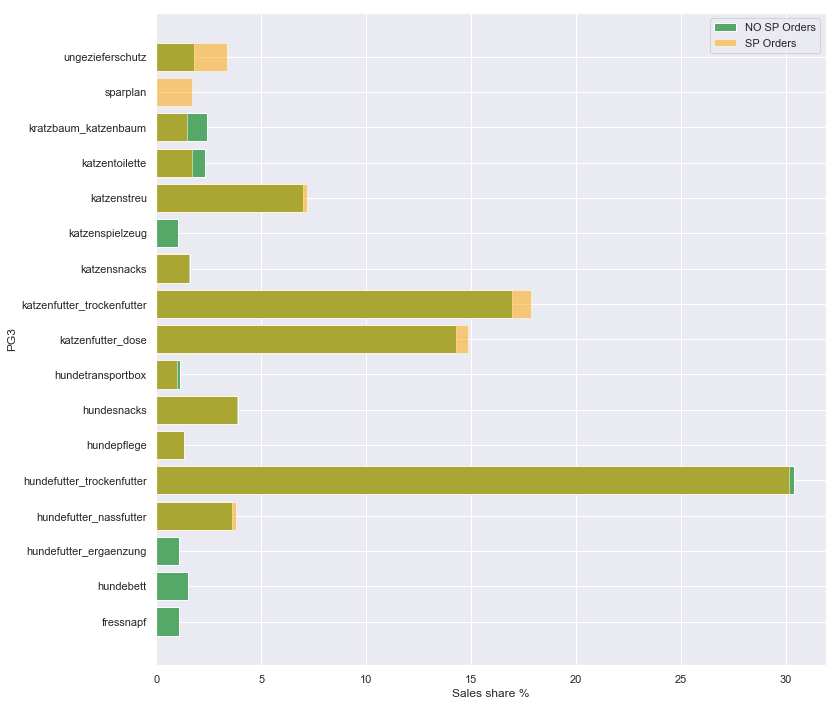

In [82]:
plt.figure(figsize=(12, 12))
x = pg3_share_comparison['PG3_NAME'].values
y = pg3_share_comparison['NO_SP_ORD'].values
z = pg3_share_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.ylabel('PG3')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [83]:
no_sp_cus_pg3_sales_df = pd.DataFrame.from_dict(no_sp_pg3_dict_sales_no_disc, orient='index')
sp_cus_pg3_sales_df = pd.DataFrame.from_dict(sp_pg3_dict_sales_no_disc, orient='index')

In [84]:
pg3_sales_comparison = pd.concat([no_sp_cus_pg3_sales_df, sp_cus_pg3_sales_df], axis=1).fillna(0)
pg3_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_sales_comparison['PG3'] = pg3_sales_comparison.index.values
#pg3_sales_comparison['PG3'] = pg3_sales_comparison['PG3'].astype(str)

In [85]:
pg3_lis = list(pg3_sales_comparison['PG3'].values)

In [86]:
pg3_lista = repr(pg3_lis).replace('[','(').replace(']',')')

In [87]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_lista

In [88]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [89]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [90]:
pg3_sales_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_sales_comparison['PG3'].values]

In [91]:
pg3_sales_comparison = pg3_sales_comparison[['PG3', 'PG3_NAME', 'NO_SP_ORD', 'SP_ORD']]
pg3_sales_comparison

,PG3,PG3_NAME,NO_SP_ORD,SP_ORD
9,9,hundebett,4933.54,3033.36
15,15,hundeleine_hundehalsband,2641.23,2478.60
16,16,fressnapf,1578.29,1612.42
18,18,hundesnacks,12835.75,14177.35
20,20,hundespielzeug,2926.30,3398.58
23,23,kratzbaum_katzenbaum,7875.14,5334.68
29,29,katzentoilette,7638.50,6191.05
33,33,fressnapf,3605.48,3240.36
34,34,katzensnacks,5263.17,5729.36
36,36,katzenspielzeug,3407.36,2376.53


##### Average Sales Share of Royal Canin products – orders with/without SP for SP customers

In [92]:
cus_scen_2b['WO_SP_BRAND_SALES'] = [x[y:z] for x, y, z in list(zip(cus_scen_2b['BRAND_AGGSALES'],
                                                     cus_scen_2b['WO_SP_1st_POS'],
                                                     cus_scen_2b['SCEN_2B_POS']))]

In [93]:
cus_scen_2b['SP_BRAND_SALES'] = [x[y:z] for x, y, z in list(zip(cus_scen_2b['BRAND_AGGSALES'],
                                                     cus_scen_2b['SCEN_2B_POS'],
                                                     cus_scen_2b['W_SP_last_POS']))]

In [94]:
cus_scen_2b['WO_SP_FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in cus_scen_2b['WO_SP_BRAND_SALES'].values]

In [95]:
no_sp_flat_brand_sales = [j for i in cus_scen_2b['WO_SP_FLAT_BRAND_SALES'].values for j in i]

In [96]:
cus_scen_2b['SP_FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in cus_scen_2b['SP_BRAND_SALES'].values]

In [97]:
sp_flat_brand_sales = [j for i in cus_scen_2b['SP_FLAT_BRAND_SALES'].values for j in i]

In [98]:
no_sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in no_sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in no_sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [99]:
sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [100]:
no_sp_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_brand_sales if str(i[0]) != 'nan'}

In [101]:
sp_dict_sales_no_disc = {i[0]: i[1] for i in sp_brand_sales if str(i[0]) != 'nan'}

In [102]:
no_sp_dict_sales_share = {a: np.round(b/sum(no_sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(no_sp_dict_sales_no_disc.keys(),
                                             no_sp_dict_sales_no_disc.values()))}

In [103]:
sp_dict_sales_share = {a: np.round(b/sum(sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(sp_dict_sales_no_disc.keys(),
                                             sp_dict_sales_no_disc.values()))}

In [104]:
sum(no_sp_dict_sales_share.values()), sum(sp_dict_sales_share.values())

(99.99900000000024, 99.99600000000017)

In [105]:
no_sp_dict_sales_share

{'Absperrgitter': 0.063,
 'Acana': 3.326,
 'Advance': 0.162,
 'Advance Breed': 0.016,
 'Advance Veterinary Diets': 0.285,
 'Affinity Advance': 1.361,
 'Agility': 0.006,
 'Aktiv & Fit': 0.027,
 'Alle Anti-Ungeziefer Produkte': 0.004,
 'Alle Hundenäpfe': 0.003,
 'Alle Hundesnacks': 0.006,
 'Alle Katzenklappen': 0.088,
 'Alle Katzenspielzeuge': 0.005,
 'Alle Zubehörartikel': 0.008,
 'Almo Nature': 0.726,
 'Almo Nature Holistic': 0.015,
 'Alpha Spirit': 0.289,
 'Animonda': 0.067,
 'Animonda Carny': 0.287,
 'Animonda Integra': 0.094,
 'Animonda Rafiné': 0.009,
 'Animonda Vom Feinsten': 0.019,
 'Applaws': 1.573,
 'Aquarien mit Unterschrank': 0.14,
 'Aquarienkies': 0.004,
 'Aquarium Komplettsets & Sets': 0.024,
 'Aquarium Unterschrank': 0.021,
 'Arden Grange': 0.395,
 'Arden Grange Partners': 0.055,
 'Augen- & Ohrenpflege': 0.082,
 'Autoschondecken': 0.225,
 'Außenfilter': 0.024,
 'Außergewöhnliche Schlafplätze': 0.07,
 'Badehäuser': 0.002,
 'Badesand & Badehäuser': 0.002,
 'Belcando': 0.103,

In [106]:
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [107]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [108]:
brands.head()

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
0,20745,20745 - Hundesofa,Hundesofa
1,2,2 - Hund,Hund
2,1422,1422 - Spielzeug,Spielzeug
3,75,75 - Hundekissen,Hundekissen
4,2157,2157 - Alle Katzenklappen,Alle Katzenklappen


In [109]:
RC_brands = brands[brands['BRAND'].str.contains('Royal Canin')][['PPR_N_LEVEL4_ID', 'BRAND']]
RC_brands

,PPR_N_LEVEL4_ID,BRAND
185,126742,Royal Canin Dog
257,17798,Royal Canin Breed (Rasse)
274,1308,Royal Canin Club / Selection
296,9702,Royal Canin Pure Feline
444,81396,Royal Canin Veterinary Diet
449,82696,Royal Canin Veterinary Diet
477,209912,Royal Canin Vet Care Nutrition
710,127037,Royal Canin Universal
790,682,Royal Canin Size
952,94525,Royal Canin


In [110]:
no_sp_rc_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [111]:
no_sp_rc_share_dict

{'Royal Canin': 4.968,
 'Royal Canin Breed (Rasse)': 2.16,
 'Royal Canin Cat': 0.002,
 'Royal Canin Club / Selection': 0.287,
 'Royal Canin Dog': 0.002,
 'Royal Canin Pure Feline': 0.006,
 'Royal Canin Rasse (Breed)': 0.38,
 'Royal Canin Size': 2.854,
 'Royal Canin Vet Care Nutrition': 0.583,
 'Royal Canin Veterinary Diet': 2.596}

In [112]:
sp_rc_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                            sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [113]:
sp_rc_share_dict

{'Royal Canin': 5.04,
 'Royal Canin Breed (Rasse)': 1.915,
 'Royal Canin Cat': 0.005,
 'Royal Canin Club / Selection': 0.152,
 'Royal Canin Pure Feline': 0.011,
 'Royal Canin Rasse (Breed)': 0.45,
 'Royal Canin Size': 2.865,
 'Royal Canin Vet Care Nutrition': 0.749,
 'Royal Canin Veterinary Diet': 3.097}

In [114]:
no_sp_rc_share_df = pd.DataFrame.from_dict(no_sp_rc_share_dict, orient='index')
sp_rc_share_df = pd.DataFrame.from_dict(sp_rc_share_dict, orient='index')

In [115]:
rc_comparison = pd.concat([no_sp_rc_share_df, sp_rc_share_df], axis=1).fillna(0)
rc_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_comparison['BRAND'] = rc_comparison.index.values
rc_comparison = rc_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,4.968,5.040
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),2.160,1.915
Royal Canin Cat,Royal Canin Cat,0.002,0.005
Royal Canin Club / Selection,Royal Canin Club / Selection,0.287,0.152
Royal Canin Dog,Royal Canin Dog,0.002,0.000
Royal Canin Pure Feline,Royal Canin Pure Feline,0.006,0.011
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),0.380,0.450
Royal Canin Size,Royal Canin Size,2.854,2.865
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,0.583,0.749
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,2.596,3.097


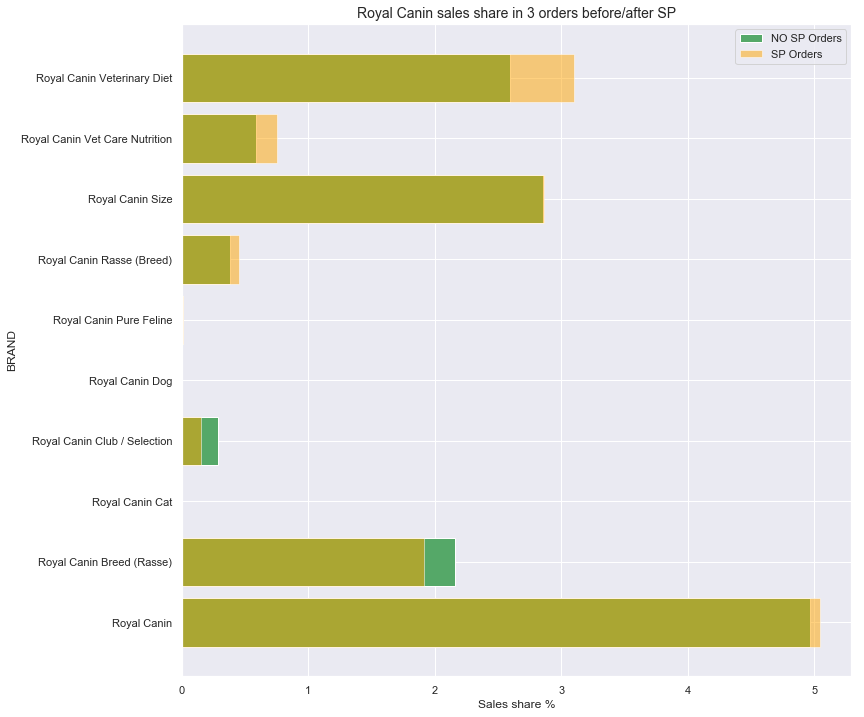

In [116]:
plt.figure(figsize=(12, 12))
x = rc_comparison['BRAND'].values
y = rc_comparison['NO_SP_ORD'].values
z = rc_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales share in 3 orders before/after SP', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

##### Average Sales Share of Hill's products – orders with/without SP for SP customers

In [117]:
Hills_brands = brands[brands['BRAND'].str.contains("Hill's")][['PPR_N_LEVEL4_ID', 'BRAND']]
Hills_brands

,PPR_N_LEVEL4_ID,BRAND
13,719,Hill's Science Plan
188,84729,Hill's Prescription Diet
261,1816,Hill's Puppy & Senior
270,2058,Hill's Natures Best
295,720,Hill's Science Plan
472,151599,Hill's Prescription Diet
735,175240,Hill's Ideal Balance
736,177843,Hill's Ideal Balance
1150,31962,Hill's Prescription Diet
1381,31963,Hill's Prescription Diet


In [118]:
no_sp_hills_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [119]:
no_sp_hills_share_dict

{"Hill's Ideal Balance": 0.011,
 "Hill's Prescription Diet": 8.881,
 "Hill's Science Plan": 2.156}

In [120]:
sp_hills_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                                 sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [121]:
sp_hills_share_dict

{"Hill's Ideal Balance": 0.037,
 "Hill's Prescription Diet": 7.817,
 "Hill's Science Plan": 2.143}

In [122]:
no_sp_hills_share_df = pd.DataFrame.from_dict(no_sp_hills_share_dict, orient='index')
sp_hills_share_df = pd.DataFrame.from_dict(sp_hills_share_dict, orient='index')

In [123]:
hills_comparison = pd.concat([no_sp_hills_share_df, sp_hills_share_df], axis=1).fillna(0)
hills_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_comparison['BRAND'] = hills_comparison.index.values
hills_comparison = hills_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Prescription Diet,Hill's Prescription Diet,8.881,7.817
Hill's Science Plan,Hill's Science Plan,2.156,2.143
Hill's Ideal Balance,Hill's Ideal Balance,0.011,0.037


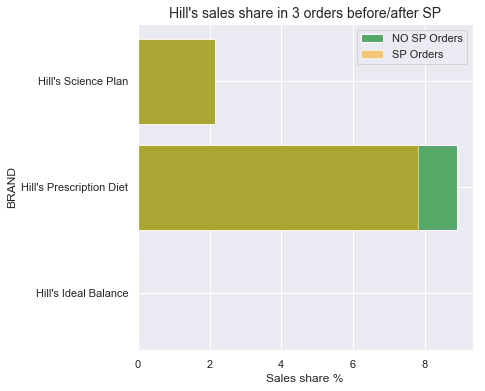

In [124]:
plt.figure(figsize=(6, 6))
x = hills_comparison['BRAND'].values
y = hills_comparison['NO_SP_ORD'].values
z = hills_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title("Hill's sales share in 3 orders before/after SP", fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

##### Timedeltas

In [125]:
cus_scen_2b.sample(5)

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,SP_DIFF_PG3,SP_DIFF_PG3_NO_DISC,SP_PG3_IDS_NO_DISC,DIFF_PG3_UP,NEW_PG3_WITH_SP,LEN_NEW_PG3_WITH_SP,WO_SP_BRAND_SALES,SP_BRAND_SALES,WO_SP_FLAT_BRAND_SALES,SP_FLAT_BRAND_SALES
243954,19430734,7,"[2018-02-14, 2018-03-14, 2018-05-25, 2018-07-1...",1114.07,"[79.17, 103.96, 174.49, 194.87, 189.06, 189.06...",289.13,"[19.74, 26.59, 47.13, 53.89, 49.09, 49.09, 43.6]",180.73,"[10.61, 13.67, 32.14, 36.06, 31.26, 31.26, 25.73]",1010.46,...,4,3,"[857, 221, 48963]",0,[48963],1,"[[(Taste of the Wild, 79.98), (Großsittichfutt...","[[(Terra Canis, 181.93), (Großsittichfutter, 9...","[(Taste of the Wild, 79.98), (Großsittichfutte...","[(Terra Canis, 181.93), (Großsittichfutter, 9...."
91191,11726442,12,"[2017-10-23, 2017-11-22, 2018-01-20, 2018-02-2...",1226.76,"[71.84, 123.81, 132.86, 93.14, 99.84, 79.5, 46...",281.09,"[17.0, 30.34, 22.27, 19.55, 21.91, 13.6, 3.36,...",129.87,"[7.32, 17.25, 6.37, 9.83, 11.67, 5.4, -5.77, 5...",1094.87,...,7,6,"[252, 2068, 251, 23, 20, 48963]",0,[48963],1,"[[(Royal Canin, 43.99), (Royal Canin Size, 9.4...","[[(Royal Canin, 44.99), (Felix, 23.99), (aus W...","[(Royal Canin, 43.99), (Royal Canin Size, 9.49...","[(Royal Canin, 44.99), (Felix, 23.99), (aus We..."
26892,5361406,16,"[2017-10-07, 2017-10-25, 2017-10-26, 2017-12-1...",820.80,"[43.98, 52.51, 41.12, 96.66, 44.59, 39.12, 23....",252.84,"[18.75, 10.71, 14.49, 28.08, 6.53, 11.73, 5.29...",40.87,"[4.51, -4.17, 6.57, 12.9, -6.81, 1.19, -1.01, ...",718.57,...,9,8,"[34, 301, 29, 33, 2068, 62, 48963, 48]",1,"[29, 2068, 62, 48963, 48]",5,"[[(Sanicat, 43.98)], [(Knuspersnacks, 28.67), ...","[[(Knuspersnacks, 40.72), (Pasten & Cremes, 24...","[(Sanicat, 43.98), (Knuspersnacks, 28.67), (Pa...","[(Knuspersnacks, 40.72), (Pasten & Cremes, 24...."
170237,16854770,6,"[2017-12-22, 2017-12-28, 2018-01-13, 2018-04-1...",581.13,"[89.99, 25.97, 116.99, 119.28, 114.45, 114.45]",131.01,"[18.32, 12.23, 29.77, 29.56, 16.57, 24.57]",81.71,"[5.21, 4.31, 22.74, 22.53, 9.39, 17.54]",520.62,...,3,2,"[251, 48963]",0,[48963],1,"[[(Gesundheitsbetten, 89.99)], [(★ Lukullus Na...","[[(Hill's Prescription Diet, 119.98), (unknown...","[(Gesundheitsbetten, 89.99), (★ Lukullus Natur...","[(Hill's Prescription Diet, 119.98), (unknown,..."
15103,3900010,14,"[2017-11-18, 2017-11-30, 2018-01-27, 2018-02-1...",753.01,"[45.9, 44.97, 50.98, 40.46, 27.98, 129.99, 44....",246.46,"[16.74, 14.64, 15.5, 14.62, 10.8, 33.28, 13.91...",92.34,"[7.59, 6.22, 6.91, -8.35, 3.99, 26.85, -5.22, ...",649.04,...,6,5,"[2068, 252, 301, 36, 48963]",0,[48963],1,"[[(Tränke/ Brunnen, 34.98), (★ Feringa, 9.0), ...","[[(Porta 21, 17.99), (★ Cosma, 16.49), (catz f...","[(Tränke/ Brunnen, 34.98), (★ Feringa, 9.0), (...","[(Porta 21, 17.99), (★ Cosma, 16.49), (catz fi..."


In [126]:
cus_scen_2b.columns

Index(['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len', 'TDT_T_KEY_ORDER_DATE_list',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES',
       'SP_DISC', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'O_TIMEDELTAS',
       'FLAT_PG3_SALES', 'FLAT_PG4_SALES', 'FLAT_BRAND_SALES',
       'TOTAL_PG3_SALES', 'TOTAL_PG4_SALES', 'TOTAL_BRAND_SALES', 'O_W_SP',
       'O_WO_SP', 'NO_SP_DISC', 'SCEN_2B', 'SCEN_2B_POS', 'WO_SP_1st_POS',
       'W_SP_last_POS', 'SALES_WO_SP', 'SALES_W_SP', 'AOV_WO_SP', 'AOV_W_SP',
       'WO_SP_CM1', 'SP_CM1', 'WO_SP_CM2', 'SP_CM2', 'WO_SP_NET_SALES',
       'SP_NET_SALES', 'WO_SP_CM1%', 'SP_CM1%', 'WO_SP_CM2%', 'SP_

In [128]:
cus_scen_2b.loc[221018]['O_TIMEDELTAS'][(cus_scen_2b.loc[221018]['WO_SP_1st_POS']):(cus_scen_2b.loc[221018]['SCEN_2B_POS'])]

[0, 10, 13]

In [129]:
cus_scen_2b.loc[221018]['O_TIMEDELTAS'][(cus_scen_2b.loc[221018]['SCEN_2B_POS']):(cus_scen_2b.loc[221018]['W_SP_last_POS']-1)]

[22, 2]

In [130]:
cus_scen_2b.loc[221018]['O_TIMEDELTAS']

[13, 7, 6, 0, 10, 13, 22, 2, 37, 8, 8, 14, 9, 4, 19, 13, 23]

In [131]:
cus_scen_2b['TD_POS1_WO_SP'] = cus_scen_2b['WO_SP_1st_POS'] 
cus_scen_2b['TD_POS2_WO_SP'] = cus_scen_2b['SCEN_2B_POS']
cus_scen_2b['TD_POS1_SP'] = cus_scen_2b['SCEN_2B_POS']
cus_scen_2b['TD_POS2_SP'] = cus_scen_2b ['W_SP_last_POS'] - 1

In [132]:
cus_scen_2b[['O_TIMEDELTAS', 'WO_SP_1st_POS', 'SCEN_2B_POS', 'W_SP_last_POS', 'TD_POS1_WO_SP', 'TD_POS2_WO_SP',
            'TD_POS1_SP', 'TD_POS2_SP']].sample(5)

,O_TIMEDELTAS,WO_SP_1st_POS,SCEN_2B_POS,W_SP_last_POS,TD_POS1_WO_SP,TD_POS2_WO_SP,TD_POS1_SP,TD_POS2_SP
214980,"[58, 57, 63, 53, 50]",0,3,6,0,3,3,5
144158,"[44, 36, 54, 28, 81, 51]",1,4,7,1,4,4,6
186776,"[10, 10, 22, 14, 39, 52, 41, 15, 29, 18, 18, 50]",4,7,10,4,7,7,9
167433,"[24, 2, 9, 20, 18, 15, 10, 10, 12, 13, 40, 13,...",16,19,22,16,19,19,21
193221,"[10, 2, 20, 22, 39, 33, 46, 47, 23, 35, 28]",1,4,7,1,4,4,6


In [133]:
cus_scen_2b['TD_BEFORE_SP'] = [a[b:c] for a, b, c in list(zip(cus_scen_2b['O_TIMEDELTAS'], cus_scen_2b['TD_POS1_WO_SP'],
                                               cus_scen_2b['TD_POS2_WO_SP']))]

In [134]:
cus_scen_2b['TD_AFTER_SP'] = [a[b:c] for a, b, c in list(zip(cus_scen_2b['O_TIMEDELTAS'], cus_scen_2b['TD_POS1_SP'],
                                               cus_scen_2b['TD_POS2_SP']))]

In [135]:
td_before_sp = [j for i in cus_scen_2b['TD_BEFORE_SP'].values for j in i]

In [136]:
td_after_sp = [j for i in cus_scen_2b['TD_AFTER_SP'].values for j in i]

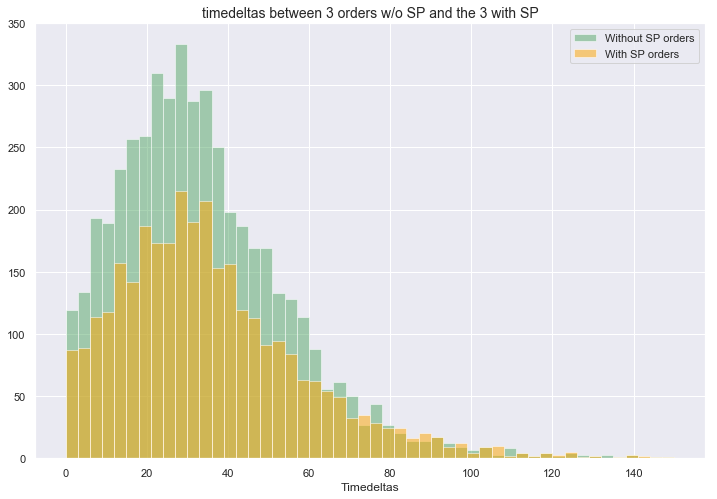

,Without SP orders,With SP orders
25%,18.00,19.00
50%,30.00,31.50
75%,45.00,47.00
count,4752.00,3168.00
max,233.00,201.00
mean,33.61,35.56
min,0.00,0.00
std,22.05,24.01


In [137]:
concat_df = pd.DataFrame()

plt.figure(figsize=(12, 8))
plt.hist(td_before_sp, bins=50, range=(0, 150), color='g', alpha=0.5)
plt.hist(td_after_sp, bins=50, range=(0, 150), color='orange', alpha=0.5)
plt.title("timedeltas between 3 orders w/o SP and the 3 with SP", fontsize=14)
plt.xlabel('Timedeltas')
plt.legend(['Without SP orders', 'With SP orders'])
plt.show()

before_sp_td = pd.DataFrame(np.array(td_before_sp).reshape(len(td_before_sp), 1), columns= ['TD_BEFORE_SP'])
after_sp_td = pd.DataFrame(np.array(td_after_sp).reshape(len(td_after_sp), 1), columns= ['TD_AFTER_SP'])

concat_df = pd.concat([concat_df,
                    before_sp_td['TD_BEFORE_SP'].describe().round(2),
                    after_sp_td['TD_AFTER_SP'].describe().round(2),
                      ], axis=1)

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)